# Цель проекта

Разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.  

# ***План проекта***

# **Часть 1**
1. Задача.
2. Метрика.
3. Описание данных.
4. Предобработка датасета (очищение данных)
5. Feature engineering
6. EDA
7. Выводы после EDA

# **Часть 2**

1. Наивная модель
2. CatBoostRegressor
3. RandomForestRegressor
4. GradientBoostingRegressor
5. StackingRegressor
6. Blending
7. Выводы


# 1. Задача

*  Очистить и подготовить данные из предоставленного датасета для использования моделью машинного обучения.
*  Построить модели машинного обучения сравнить их и выбрать лучшую на основе выбраной метрики.



# 2. Метрика

Расматривалось 2 метрики для оценки и сравнения моделей MAPE и MAE.

*   Выбрана метрика MAPE(mean percentage absolute error). Метрика показывает на сколько в среднем в процентах ошибаеться модель. Это удобно для сравнения моделей.
*   MAE было решено использовать дополнительно, так как она отображает абсолютное число ошибки, что не очень удобно.


# 3. Описание данных

1. status - статус недвижимости. 
2. private pool - наличие бассейна.
3. propertyType - тип недвижимости.
4. street - адрес
5. baths - описание санузла.
6. homeFacts - описание недвижимости.(json dataset)
7. fireplace - наличие камина и его описание.
8. city - город.
9. schools - наличие школ и доп. данные о них.(json dataset)
10. sqft  - площадь обьекта.
11. zipcode - почтовый индекс.
12. beds - спальные.
13. state - штат.
14. stories - количество этажей.
15. mls-id - номер обьявления в реестре недвижимости.
16. PrivatePool - наличие бассейна.
17. MlsId - номер обьявления в реестре недвижимости.
18. target - целевая переменная.




In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 4. Предобработка (очистка) данных.

# Импорты

In [4]:
from google.colab import drive
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import re

import collections

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split


# инструменты для оценки точности модели 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae


# модуль для работы с полиноминальными признаками
from sklearn.preprocessing import PolynomialFeatures


# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Модули для нахождения выбросов
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#
from IPython.display import display


# Модуль для вывода прогресса
from tqdm.notebook import tqdm

# Модули алгоритмов
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


import statistics as st


from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import json
import re


# Настройки Pandas

In [5]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Функции для EDA

In [6]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

def get_quantile(df, column):
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr

    print('Верхняя граница выбросов:',
          l, 'Нижняя граница выбросов:', f)
    print()
    #считаем количество выбросов
    print('Количество выбросов:', column, ':',
         df[df[column]<(perc25-1.5*iqr)][column].count() +
          df[df[column]>(perc75+1.5*iqr)][column].count())
    
def get_filling_mean(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: df[column].mean() if m < f else m)
    df[column] = df[column].apply(lambda m: df[column].mean() if m > l else m)
    
def get_filling_lim(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: perc25 if m < f else m)
    df[column] = df[column].apply(lambda m: perc75 if m > l else m)


def get_filling_mean(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: df[column].mean() if m < f else m)
    df[column] = df[column].apply(lambda m: df[column].mean() if m > l else m)


# Функции

In [7]:
# Функции

# Функция для изменнения строк
def form_status(x):
  x = re.sub('foreclosure', 'for sale', x)
  x = re.sub('pending', 'for sale', x)
  x = re.sub('auction', 'for sale', x)
  x = re.sub('contract', 'for sale', x)
  x = re.sub('coming', 'for sale', x)
  x = re.sub('closed', 'for sale', x)
  x = re.sub('foreclosed', 'for sale', x)
  x = re.sub('price change', 'for sale', x)
  x = re.sub('back', 'for sale', x)
  x = re.sub('continue show', 'for sale', x)
  x = re.sub('listing', 'for sale', x)
  x = re.sub('accepting', 'for sale', x)
  x = re.sub('activated', 'for sale', x)
  x = re.sub('lease/purchase', 'for sale', x)
  x = re.sub('sold', 'active', x)
  x = re.sub('recently sold', 'active', x)
  x = re.sub('active - auction', 'for sale', x)


  return x

# Функция для создания списка категорий
def quant_class(a):
    cnt = collections.Counter()
    for i in a:
        for j in i:
            j = str(j)
            cnt[j] += 1
    return cnt 

# Функция для создания DUMMY признаков из столбца 
def create_dummies(df, col, lst):
    for elem in lst:
        df[elem] = df[col].apply(lambda x: 1 if elem in x else 0)
    return df

# Функция для форматирования строк в списках столбца propertyType_1
def form_propertyType_1(x):
    a = []
    for i in x:
      if i[0] == ' ':
        i = i[1:]
      else: i = i
      a.append(i)
    return a


def form_propertyType_2(x):
  a = []
  mapper = {'co-op':'coop','one story':'1 story','two story':'2 stories','2 story':'2 stories',
            'unknown': '','1 1':'','townhome':'townhouse','manufactured home':'manufactured house',
            'multi-family':'multi family',' ': ''}

  for i in x:
      if i in mapper:
        i = mapper[i]

  return x          



# Преобразования fireplace
def form_fireplace_1(x):
    a = []
    for i in x:
      if i[0] == ' ':
        i = i[1:]
      else: i = i
      a.append(i)
    return a




# Преобразования fireplace
def form_fireplace_2(x):
  a = []
  mapper = {'gas log':'gas logs','gas fireplace':'gas','one':'1','familyrm':'family room','# fireplaces - woodburning':'1, wood burning','# fireplaces - gas':'1, gas',
            'fireplaces':'1','# fireplaces - woodstoves':'woodstoves','gas fuel':'gas','in great room':'great room','familyrm':'family room','in living room':'living room',
            'in den':'den','1 fireplace':'1','fireplace family rm':'family room','woodburning stove':'wood burning','log woodburning':'wood burning','fireplace-gas':'gas',
            'gas fireplace':'gas','log wood-burning':'wood burning','fireplace-wood':'wood burning','fire pit':'firepit','fireplace living rm':'living room',
            'wood burning frplc':'wood burning','fireplace - wood burning':'wood burning','wood burning fp':'wood burning','gas log starter':'gas starter','no fireplace':'0',
            'two':'2','2 fireplaces':'2','fireplace':'1','three':'3','2 fireplace':'2','in bedroom':'bedroom','fireplace master bdr':'bedroom','two way fireplace':'two way',
            'gas logs included':'gas logs','living room fireplace':'living room','single fireplace':'1','frplc-fam rm':'family room','gr':'great room','fireplace in family room':'family room',
            'gas burning fireplace':'gas','fireplace - gas':'gas','3+ fireplace':'3','in rec room':'rec room','gas burning':'gas','freestnd fireplace':'free standing',
            'basement - finished':'basement','family room fireplace':'family room','wood burning fireplace':'wood burning','gas log fireplace':'gas logs','wood burning w':'wood burning',
            'great room fireplace':'great room','location (living room)':'living room','3 fireplaces':'3','two sided':'two way','fireplace-living rm':'living room',
            'fp in living room':'living room','woodstove':'wood stove','living':'living room','free-standing':'free standing','brick fireplace':'brick','ceiling fan(s)':'ceiling fan',
            'walk-in closet(s)':'walk-in closet','in kitchen':'kitchen','basement fireplace':'basement','# fireplaces - freestanding':'free standing','decorative fireplace':'decorative',
            'decorative only':'decorative','fp in family room':'family room','fireplace(s)':'1','2+ fireplaces':'2','dining':'dining room','multi-sided fireplace':'two way',
            'in family room':'family room','2 sided fire place':'two way','in master bedroom':'master bedroom','bedroom':'master bedroom','master bedroom fireplace':'master bedroom',
            'fireplace-bedroom':'master bedroom','master bedroom - sitting area':'master bedroom','dining area':'dining room','four or more':'4','wood stove insert':'wood stove',
            'fireplace- gas':'gas','two-way':'two way','wood-burning stove':'wood stove','gas piped':'gas','non wood burning': 'gas','wood fuel':'wood stove','# fireplaces - pellet':'pellet',
            'propane logs convey': 'gas','bed room fireplace':'bed room','free standing wood stove': 'wood stove','masonry fireplace': 'stone fireplace','masonry':'stone fireplace',
            'w':'wood stove','family':'family room','recreation room fireplace':'recreation room','rec room':'recreation room','gas log(s)':'gas logs','double sink': 'two way',
            'in living area':'living room','fireplace in master bedroom':'master bedroom','master':'master bedroom','gas-burning':'gas','2 or more fireplaces':'2','gas starter fireplace':'gas starter',
            'master suite': 'master bedroom','2 sided fireplace': 'two way','three or more':'3','electric logs':'electric','electric fireplace':'electric','fireplace - electric':'electric',
            '4+ fireplaces':'4','formal dining room':'dining room','double sink': 'two way','multi sided': 'two way','oven': '1','attached fireplace doors':'attached doors','balcony access':'balcony',
            'basement - partially finished':'basement','bed room':'bedroom','cable tv available': 'cable tv','cathedral ceiling': 'cathedral','ceiling fans':'ceiling fan','central furnace': 'central air',
            'central heat': 'central air','central vacuum': 'central air','dining room combo':'dining room','dining room fireplace':'dining room','exterior fireplace':'extras','fireplace- wood':'wood burning',
            'forced warm air': 'forced air','fp in master br': 'master bedroom','free standing frplc': 'free standing','freestanding': 'free standing','gas starters':'gas starter',
            'gas ventless':'gas unvented','heatilater':'heatilator','heatilator type system':'heatilator','heating system: yes(s)': 'heatilator','in-law apt': 'in-law quarters',
            'in-law suite': 'in-law quarters','insert unit':'insert','kitchen - gas cooking':'kitchen','kitchen fireplace':'kitchen','marble fireplace':'marble','master bedroom - dressing area': 'master bedroom',
            'natural gas':'gas','non-functional fireplace': 'non-functional','not applicable': 'non-functional','other (see remarks)':'other','other - see remarks':'other','other-see remarks':'other',
            'outdoors':'outdoor','outside':'outdoor','pellet stove':'pellet','pre-fab':'prefabricated','prefab':'prefabricated','presently inoperative':'non-functional','propane': 'gas','propane stove': 'gas',
            'rec room fireplace': 'recreation room','see thru': 'see through','separate dining':'dining room','stone fireplace':'stone','storage lockers':'storage','vented gas fireplace':'vented gas',
            'walk-in closets':'walk-in closet','wall mounted': 'wall furnace','window treatments': 'window treatment','with gas logs': 'gas logs','wood':'wood burning','woodburning':'wood burning',
            'wood burning stove': 'wood stove','woodstoves': 'wood stove','in study': 'study','yes' : '1','fireplace' : '1','1 fireplace' : '1','no' : '0','3+' : '3','gas log' : 'gas logs','gas fireplace' : 'gas',
            'one' : '1','familyrm' : 'family room' ,'in living room' : 'living room' ,'# fireplaces - woodburning' : '1, wood burning','# fireplaces - gas' : '1, gas','fireplaces' : '1','# fireplaces - woodstoves' : 'woodstoves',
            'gas fuel' : 'gas','3+' : '3','gas log' : 'gas logs','gas fireplace': 'gas','one' : '1' ,'familyrm' : 'family room' ,'in living room' : 'living room' ,'# fireplaces - woodburning' : '1, wood burning',
            '# fireplaces - gas' : '1, gas','fireplaces' : '1','# fireplaces - woodstoves' : 'woodstoves','gas fuel' : 'gas',}


  for i in x:
      if i in mapper:
        i = mapper[i]

  return x      




# Преобразования form_homeFacts
def form_homeFacts_re(x):
  x = re.sub(r': None,', ': "None",', x)
  x = re.sub(r'Attch"d', 'Attchd', x)
  x = re.sub(r'Req"d', 'Reqd', x)
  x = re.sub(r'Hennen"s', 'Hennens', x)
  x = re.sub(r'"closet"', 'closet', x)
  x = re.sub(r'Addtn"l', 'Addtnl', x)
  x = re.sub(r'Penske"s', 'Penskes', x)
  #x = x[20:-2]

  return x


# Преобразования propertyType
def form_propertyType_s(x):
  x = str(x)
  x = re.sub('single', 'houses', x)
  x = re.sub('story', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('bungalow', 'houses', x)
  x = re.sub('home', 'houses', x)
  x = re.sub('transitional', 'houses', x)
  x = re.sub('contemporary', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('residential','houses', x)
  x = re.sub('level','houses', x)
  x = re.sub('custom','houses',x)
  x = re.sub('cottage','houses',x)
  x = re.sub('house','houses',x)
  x = re.sub('detached','houses', x)
  x = re.sub('stor','houses', x)
  x = re.sub('attached','houses', x)
  x = re.sub('residential','houses', x)
  x = re.sub('coach','houses', x)

  x = re.sub('townhome', 'townhouse', x) 
  x = re.sub("plex", 'townhouse', x)

  x = re.sub('high rise', 'condo', x)
  x = re.sub('coop', 'condo', x)
  x = re.sub('coop', 'condo', x)
  x = re.sub('less than 4 floors','condo', x)
  x = re.sub('unit','condo',x)
  x = re.sub('co-op','condo', x)
  x = re.sub('rise','condo', x)
  x = re.sub('loft','condo', x)
  x = re.sub('penthouse', 'apartment', x)
  
  x = re.sub('lot', 'land', x)

  x = re.sub('multi', 'multi-family', x)
  x = re.sub('split','multi-family', x)

  x = re.sub('mediterranean','style house', x)
  x = re.sub('cape','style house', x)
  x = re.sub('modern','style house', x)
  x = re.sub('craftsman','style house',x)
  x = re.sub('victorian','style house', x)
  x = re.sub('spanish','style house',x)
  x = re.sub('miscellaneous','style house',x)
  x = re.sub('colonial','style house', x)
  x = re.sub('key west','style house',x)
  x = re.sub('santa barbara','style house', x)
  x = re.sub('straight','style house', x)
  x = re.sub('french','style house', x)
  x = re.sub('english','style house', x)
  x = re.sub('georgian','style house', x)
  x = re.sub('european','style house', x)
  x = re.sub('elevated','style house', x)
  x = re.sub('art','style house', x)
  x = re.sub('historical','style house',x)
  x = re.sub('frame','style house', x)
  x = re.sub('charleston','style house', x)
  x = re.sub('tudor','style house', x)
  x = re.sub('florida','style house', x)
  x = re.sub('federal','style house', x)
  x = re.sub('ranch','style house', x)
  x = re.sub('colonial','style house', x)
  x = re.sub('modern','style house', x)
  x = re.sub('contemporary','style house', x)

  x = re.sub('other','other', x)

  return x

# Преобразования fireplace
def form_fireplace_3(x):
  x = str(x)
  x = re.sub('# fireplaces - artificial', 'decorative', x)
  x = re.sub('1000+ sq. ft.', '0', x)
  x = re.sub('134', '0', x)
  x = re.sub('2 story', '0', x)
  x = re.sub('3 bedrooms', 'no', x)
  x = re.sub('4+', '4', x)
  x = re.sub('attached screens', 'attached doors', x)
  x = re.sub('bed room', 'bedroom', x)
  x = re.sub('bedroom downstairs', 'bedroom features', x)
  x = re.sub('electric baseboard', 'electric', x)  
  x = re.sub('fireplace - other', 'fireplace-other', x) 
  x = re.sub('fireplace-other', 'other', x)  
  x = re.sub('hoa', '0', x)  
  x = re.sub('more baths', 'bath', x)  
  x = re.sub('stone fireplace', 'stone', x)  
  x = re.sub('recreation room', 'rec room', x) 
  x = re.sub('two+', '2', x)  
  x = re.sub('wall furnace', 'wall', x)  

  return x


# Преобразования scools.
def form_scools_re(x):
  x = re.sub('\w\"\w', '', x)
  x = re.sub('\"Duke\"', '', x) 
  x = re.sub("None/10", '', x)
  x = re.sub('""', '"None"', x)
  x = re.sub(', None,', ', "None",', x)
  x = re.sub('Lil" Wonders', '', x)
  x = re.sub('Loggers"', '', x)
  x = re.sub('O"', '', x)
  x = re.sub('N"', '', x)
  x = re.sub('Citizens"', 'Citizens', x) # 7033
  x = re.sub('Yeshivat Shaare Torah Girls" D', 'Yeshivat Shaare Torah Girls D', x) 
  x = re.sub(r'Boy\\\\"s Prep School', 'Boys Prep School', x) # 10452
  x = re.sub(r'Kids" World Private School, Inc. & Cornerstone Academy of Los Angeles', 'Kids World Private School, Inc. & Cornerstone Academy of Los Angeles', x) # 18535
  x = re.sub('Seattle Girls" Private School', 'Seattle Girls Private School', x) # 32242
  x = re.sub('Constellation Schools: Westside Community School ', 'Constellation Schools: Westside Community School"', x) # 34600
  x = re.sub('Kids "R" Kids of Katy Private School', 'Kids R Kids of Katy Private School', x) # 44538
  x = re.sub('Jose "joe" May Elementary School', 'Jose joe May Elementary School', x) # 67663
  x = re.sub('G E "buddy" West Elementary School', 'G E buddy West Elementary School', x) # 106000
  x = re.sub('My Small-Sized Friends" Elementary Academy Private School', 'My Small-Sized Friends Elementary Academy Private School', x) # 106238
  x = re.sub('Mary Harris "Mother" Jones Elementary School', 'Mary Harris Mother Jones Elementary School', x)
  return x



# Функция для приведения столбца sqft к числовому виду.
def form_sqft(x):
  x = re.sub(r'sqft', '', x)
  x = re.sub(r'Total interior livable area: ', '', x) 
  x = re.sub(r',', '', x)
  x = re.sub(r'--', '', x) 
  x = re.sub(r'-', '', x) 
  x = re.sub(r' ', '', x)
  if x == '':
      x = np.nan
  x = float(x)
  if x == 0.0:
    x = np.nan

  return x


# Функция для замены бессмысленных значений на nan
def form_beds(x):
  if 'sqft' in x:
    x = np.nan
  elif 'Bath' in x:
    x = np.nan
  elif 'acres' in x:
    x = np.nan
  elif 'acre' in x:
    x = np.nan
  elif '--' in x:
    x = np.nan
  elif x == "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.":
    x = np.nan
  elif x == "Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.":
    x = np.nan
  elif x == " ":
    x = np.nan
  return x


# Функция для форматирования строк stories
def form_stories(x):
  x = re.sub(r'One', '1', x)
  x = re.sub(r'Two', '2', x) 
  x = re.sub(r'2 Story', '2', x)
  x = re.sub(r'1 Story', '1', x) 
  x = re.sub(r'3+', '3', x) 
  x = re.sub(r'Three Or More', '3', x)
  x = re.sub(r'One Story', '1', x)
  x = re.sub(r'Two Story or More', '2', x) 
  x = re.sub(r'2 Stories', '2', x)
  x = re.sub(r'3 Story', '3', x) 
  x = re.sub(r'2 Level, Site Built', '2', x) 
  x = re.sub(r'2 Level', '2', x)
  x = re.sub(r'Ranch/1', '1', x)
  x = re.sub(r'1 Level', '1', x) 
  x = re.sub(r'2 or More', '2', x) 
  x = re.sub(r'1.5 Story', '1.5', x)
  x = re.sub(r'1 Level, Site Built', '1', x) 
  x = re.sub(r'1 Basement', '1', x)
  x = re.sub(r'2/Basement', '2', x)
  x = re.sub(r'2 Or More Stories', '2', x) 
  x = re.sub(r'Tri-Level', '3', x)
  x = re.sub(r'4 Story', '4', x) 
  x = re.sub(r'2.5 Story', '2.5', x) 
  x = re.sub(r'Bi-Level', '2', x)
  x = re.sub(r'1, Site Built', '1', x) 
  x = re.sub(r'1.5 Level, Site Built', '1.5', x)
  x = re.sub(r'2s', '2', x) 
  x = re.sub(r'1.5/Basement', '1.5', x) 
  x = re.sub(r'1/Ranch', '1', x)
  x = re.sub(r'3 Level, Site Built', '3', x)
  x = re.sub(r'1.5/Basement', '1.5', x) 
  x = re.sub(r'1.5 Stories', '1.5', x) 
  x = re.sub(r'1, 2', '1', x)
  x = re.sub(r'1/F.R.O.G.', '1', x) 
  x = re.sub(r'3 - 5 Stories', '3', x)
  x = re.sub(r', 2', '2', x)
  x = re.sub(r'3 Level, Site Built, Townhouse', '3', x) 
  x = re.sub(r'3 Stories', '3', x)
  x = re.sub(r'6+ Stories', '6', x) 
  x = re.sub(r'1, Condo', '1', x) 
  x = re.sub(r'Triplex', '3', x)
  x = re.sub(r'Multi Level, Tri Level', '3', x) 
  x = re.sub(r'1-2, 3-4 Stories', '1', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x)
  x = re.sub(r'Double Wide', '2', x) 
  x = re.sub(r'3, 3', '3', x)
  x = re.sub(r'Ground Level2', '2', x)
  x = re.sub(r'Multi/Split2', '2', x) 
  x = re.sub(r'1, Hillside', '1', x)
  x = re.sub(r'1, 1', '1', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'3, Tri Level', '3', x)
  x = re.sub(r'2.5/Basement', '2.5', x) 
  x = re.sub(r'3 Level, Condo, Site Built', '3', x)
  x = re.sub(r'1and + Loft', '1', x) 
  x = re.sub(r'2, Split Foyer', '2', x) 
  x = re.sub(r'2, Split Level', '2', x)
  x = re.sub(r'2, Tri Level', '2', x) 
  x = re.sub(r'2, Townhouse', '2', x)
  x = re.sub(r'1 and 1 Half, 3', '3', x)
  x = re.sub(r'4 Stories', '4', x) 
  x = re.sub(r'1, Multi Level', '1', x)
  x = re.sub(r'1, Split Foyer', '1', x) 
  x = re.sub(r'Ground Level, Split Level2', '2', x) 
  x = re.sub(r'Split Foyer, 3', '3', x)
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'2 or 2', '2', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'1, Non-Site Built', '1', x)
  x = re.sub(r'2, Multi/Split', '2', x) 
  x = re.sub(r'1and + Loft', '1', x)
  x = re.sub(r'Multi Level, Three or More', '3', x)
  x = re.sub(r'1.5, 3', '3', x) 
  x = re.sub(r'2, Tear Down', '2', x)
  x = re.sub(r'3, Split Level', '3', x) 
  x = re.sub(r'Quad Level', '4', x) 
  x = re.sub(r'3, Multi Level', '3', x)
  x = re.sub(r'1, Split Level', '1', x) 
  x = re.sub(r'T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'1, Multi/Split', '1', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x)
  x = re.sub(r'Tri/Multi Level', '3', x) 
  x = re.sub(r'2, Multi Level', '2', x) 
  x = re.sub(r'2, Condo, Site Built', '3', x) 
  x = re.sub(r'1 1/2', '1', x) 
  x = re.sub(r', 3', '3', x)
  x = re.sub(r'3+ Story', '3', x) 
  x = re.sub(r'3-4', '3', x) 
  x = re.sub(r'Ground Level, 1', '1', x) 
  x = re.sub(r'2, Condo', '2', x)
  x = re.sub(r'3 Level, Townhouse', '3', x) 
  x = re.sub(r'Tri Level', '3', x) 
  x = re.sub(r'3, Townhouse', '3', x) 
  x = re.sub(r'3 Level', '3', x)
  x = re.sub(r'6+ Stories', '6', x) 
  x = re.sub(r'1, Townhouse', '1', x) 
  x = re.sub(r'Duplex', '2', x) 
  x = re.sub(r'3/Basement', '3', x)
  x = re.sub(r'3, Multi/Split', '3', x) 
  x = re.sub(r', 1', '1', x) 
  x = re.sub(r'1and + Loft', '1', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x)
  x = re.sub(r'T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'Site Built3 ', '3', x) 
  x = re.sub(r'1 and 1 Half', '1.5', x) 
  x = re.sub(r'1.5 Level', '1.5', x)
  x = re.sub(r'3+', '3', x)

  return x



# Функция для изменения строк heating.
def form_heating_re(x):

  x = re.sub(r'\([^()]*\)', '', x)
  x = re.sub(r'forced air', 'forced air', x)
  x = re.sub(r'central, electric', 'central electric', x) 
  x = re.sub(r', electric hot air', 'electric hot air', x)
  x = re.sub(r', gas hot air/furnace', 'gas hot air/furnace', x)
  x = re.sub(r', natural gas', 'natural gas', x)
  x = re.sub(r', multizone heat', 'multizone heat', x)
  x = re.sub(r', g-fresh air ventilation', 'g-fresh air ventilation', x)
  x = re.sub(r', gas water heater', 'gas water heater', x)
  x = re.sub(r'radiators', 'radiator', x)
  x = re.sub(r', heat pump - heat', 'heat pump - heat', x)
  x = re.sub(r', electric baseboard heat', 'electric baseboard heat', x)
  x = re.sub(r'gas gas', 'gas', x)
  x = re.sub(r'wall units / window unit', 'wall/window unit', x)
  x = re.sub(r'window units', 'window unit', x)
  x = re.sub(r', g-energy star hvacgas hot air/furnace', 'g-energy star hvacgas hot air/furnace', x)
  x = re.sub(r', pellet', 'pellet', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacegas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r'electric hot airg-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnaceheat pump - heatmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvac, gas floor furnacegas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'garage-tankless, gas', 'garage-tankless', x)
  x = re.sub(r'garage-tankless h2o', 'garage-tankless', x)
  x = re.sub(r'garage-tankless water heater', 'garage-tankless', x)
  x = re.sub(r'tank in garage and tankless upstairs-gas', 'garage-tankless', x)
  x = re.sub(r'garage-natural gas on demand', 'garage-on-demand navien', x)
  x = re.sub(r'propane/butane', 'propane', x)
  x = re.sub(r'propane butane', 'propane', x)
  x = re.sub(r'propane gas', 'propane', x)
  x = re.sub(r'propane-owned', 'propane', x)
  x = re.sub(r'gas - liquid propane bottlepellet', 'liquid propane', x)
  x = re.sub(r'gas - liquid propane bottle', 'liquid propane', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r', ceiling heating', 'ceiling heating', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r'stove - wood', 'wood stove', x)
  x = re.sub(r'stove', 'wood stove', x)
  x = re.sub(r'wood burn stove', 'wood stove', x)  
  x = re.sub(r'wood/coal', 'wood stove', x)
  x = re.sub(r'coal', 'wood stove', x)
  x = re.sub(r'zoneddd', 'zoned', x)
  x = re.sub(r'wood burning furnace', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)


  if x == '':
    x = np.nan

  return x


# Функция для изменения строк cooling.
def form_cooling_re(x):

  x = re.sub(r'\([^()]*\)', '', x)
  x = re.sub(r'forced air', 'forced air', x)
  x = re.sub(r'central, electric', 'central electric', x) 
  x = re.sub(r', electric hot air', 'electric hot air', x)
  x = re.sub(r', gas hot air/furnace', 'gas hot air/furnace', x)
  x = re.sub(r', natural gas', 'natural gas', x)
  x = re.sub(r', multizone heat', 'multizone heat', x)
  x = re.sub(r', g-fresh air ventilation', 'g-fresh air ventilation', x)
  x = re.sub(r', gas water heater', 'gas water heater', x)
  x = re.sub(r'radiators', 'radiator', x)
  x = re.sub(r', heat pump - heat', 'heat pump - heat', x)
  x = re.sub(r', electric baseboard heat', 'electric baseboard heat', x)
  x = re.sub(r'gas gas', 'gas', x)
  x = re.sub(r'wall units / window unit', 'wall/window unit', x)
  x = re.sub(r'window units', 'window unit', x)
  x = re.sub(r', g-energy star hvacgas hot air/furnace', 'g-energy star hvacgas hot air/furnace', x)
  x = re.sub(r', pellet', 'pellet', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacegas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r'electric hot airg-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnaceheat pump - heatmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvac, gas floor furnacegas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'garage-tankless, gas', 'garage-tankless', x)
  x = re.sub(r'garage-tankless h2o', 'garage-tankless', x)
  x = re.sub(r'garage-tankless water heater', 'garage-tankless', x)
  x = re.sub(r'tank in garage and tankless upstairs-gas', 'garage-tankless', x)
  x = re.sub(r'garage-natural gas on demand', 'garage-on-demand navien', x)
  x = re.sub(r'propane/butane', 'propane', x)
  x = re.sub(r'propane butane', 'propane', x)
  x = re.sub(r'propane gas', 'propane', x)
  x = re.sub(r'propane-owned', 'propane', x)
  x = re.sub(r'gas - liquid propane bottlepellet', 'liquid propane', x)
  x = re.sub(r'gas - liquid propane bottle', 'liquid propane', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r', ceiling heating', 'ceiling heating', x)
  x = re.sub(r'zoneddd', 'zoned', x)
  x = re.sub(r'wood burning furnace', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r'heat pump - ac', 'heat pump', x)
  x = re.sub(r'wall or window unit', 'wall/window unit', x)
  x = re.sub(r'wall ac units', 'wall', x)
  x = re.sub(r'wall unit', 'wall', x)
  x = re.sub(r'wall unit cooling', 'wall', x)
  x = re.sub(r', multizonedd a/c', 'multizonedd a/c', x)
  x = re.sub(r'multi zonedd', 'multizonedd a/c', x)
  x = re.sub(r'central,', 'central', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r'stove - wood', 'wood stove', x)
  x = re.sub(r'g-sealed combustion fireplace/wood stove', 'g-sealed combustion fireplace, wood stove', x)
  x = re.sub(r'furnace - wood/oil combo', 'wood stove', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r', wall - ac', 'wall - ac', x)


  if x == '':
    x = np.nan

  return x

# Функция для изменения строк parking.

def parking(x):
  x = str(x)
  x = re.sub('2','2 spaces',x)
  x = re.sub('4','4 spaces',x)
  x = re.sub('3','3 spaces',x)
  x = re.sub('parking desc','4 spaces',x)
  x = re.sub('off street parking','off street',x)
  x = re.sub('garage - 2 car','2 spaces',x)
  x = re.sub('attached - front','attached garage',x)
  x = re.sub('6','6 spaces',x)
  x = re.sub('garage-attached','attached garage',x)  
  x = re.sub('attached - side','attached garage',x)
  x = re.sub('attached','attached garage',x)
  x = re.sub('carport spaces','carport',x)
  x = re.sub('garage attached','attached garage',x)
  x = re.sub('5','5 spaces',x)
  x = re.sub('attached - rear','attached garage',x)
  x = re.sub('attached - side','attached garage',x) 
  x = re.sub('attached - front','attached garage',x)
  x = re.sub('8','8 spaces',x)
  x = re.sub('0','0 spaces',x)
  x = re.sub('garage - 2 spaces car','2 spaces',x)
  x = re.sub('aggre','nan',x)
  x = re.sub('circular driveway','ndrivewayan',x)
  x = re.sub('driveway paved','driveway',x)
  x = re.sub('parking driveway','driveway',x)
  x = re.sub('parking/driveway','driveway',x)
  x = re.sub('driveway description','driveway',x)
  x = re.sub('driveway only','driveway',x)
  x = re.sub('concrete driveway','driveway',x)
  x = re.sub('asphty','driveway',x)
  x = re.sub('drvwy','driveway',x)
  x = re.sub('concr','driveway',x)
  x = re.sub('detached','detached garage',x)
  x = re.sub('driveway - concrete','driveway',x)
  x = re.sub('8 spaces8 spaces8 spaces','8 spaces',x)
  x = re.sub('garage garage','garage',x)
  x = re.sub('spaces spaces','spaces',x)

  return x

# Функция для приведения столбца lotsize к числовому виду.
def form_lotsize(x):
  x = x.replace("sq.", "", 1)
  x = x.replace("ft.", "", 1)
  x = re.sub(r'acres', '', x)
  x = re.sub(r'acres lot', '', x)
  x = re.sub(r'lot', '', x)
  x = re.sub(r'sqft', '', x)
  x = re.sub(r'(sq.ft)', '', x)
  x = re.sub(r'acre', '', x)
  x = re.sub(r'[—]', '', x)
  x = re.sub(r'Total interior livable area: ', '', x) 
  x = re.sub(r',', '', x)
  x = re.sub(r'--', '', x) 
  x = re.sub(r'-', '', x) 
  x = re.sub(r' ', '', x)
  x = re.sub(r'^0', '0.', x)
  x = x.replace("..", ".", 1)

  return x


# Функция для приведения столбца price_sqft к числовому виду.
def price_sqft(x):

  x = re.sub(r'/sqft', '', x)
  x = re.sub(r' / sq. ft.', '', x)
  x = x.replace(r'$', '', 1)
  x = re.sub(r'no info', '', x)
  x = re.sub(r',', '', x)
  x = re.sub(r'contact manager', '', x)

  return x

# Функция для приведения столбца rating к числовому виду.
def price_rating(x):
  x = re.sub(r'1/10', '1', x)
  x = re.sub(r'2/10', '2', x)
  x = re.sub(r'3/10', '3', x)
  x = re.sub(r'4/10', '4', x)
  x = re.sub(r'5/10', '5', x)
  x = re.sub(r'6/10', '6', x)
  x = re.sub(r'7/10', '7', x)
  x = re.sub(r'8/10', '8', x)
  x = re.sub(r'9/10', '9', x)
  x = re.sub(r'10/10', '10', x)
  x = re.sub(r'None', '0', x)
  x = re.sub(r'NR', '0', x)
  x = re.sub(r'NA', '0', x)


  return x



# Создадим функцию которая уберет все буквы.
def del_str(x):
  x = ''.join(i for i in x if not i.isalpha())
  return x

# Инициализация диска

In [8]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
!ls /content/gdrive/

MyDrive


In [10]:
!ls /content/gdrive/"My Drive"

'Colab Notebooks'   SWOT.gsheet		       'Новая таблица.gsheet'
 Colab_Notebooks    TEMNIAKOVA_08_2021.gsheet   Остальное
 datasets	    TEMNIAKOVA_08_2021.xls     'Таблицы DataScience'
 Diplom_project    'Книги по IT'


In [11]:
!cp /content/gdrive/'My Drive'/Diplom_project/data.csv .


In [12]:
!ls

catboost_info  data.csv  gdrive  sample_data


In [13]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', 20)

# Загрузка датасета

In [14]:
df = pd.read_csv('data.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Target

### Функция

In [14]:
def col_target(df,col):
  
  # Посмотрим если в Target есть пропуски
  print('Пропуски:')
  print(df[col].isna().value_counts())

  # Удалим их
  df.dropna(subset = [col],inplace = True)

  # Ecть одно значение цены от и до суммы. обьявление аренды возьмем среднее етой цены.
  df[col] = df[col].apply(lambda x: '1326' if x == '$1,215 - $1,437/mo'  else x)

  # Убираем все знаки.
  df[col] = df[col].str.replace(r'\D+', '', regex=True)

  # Приведем все значения к float 
  df[col] = df[col].astype(float)
  print('Пропуски после обработки:')
  print(df[col].isna().value_counts())

  return df


### Target

In [15]:
df = col_target(df,'target')

Пропуски:
False    374704
True       2481
Name: target, dtype: int64
Пропуски после обработки:
False    374704
Name: target, dtype: int64


# Столбец 'status'

### Функция

In [16]:
def col_status(df, col):
  
  # Приводим к нижнему регистру
  df['status'] = df['status'].str.lower()

  # Создадим список из столбца status
  status_list = df['status'].unique().tolist()

  # Заполним пропуски строками nan
  df['status'].fillna('nan', inplace = True)
  df['status'] = df['status'].apply(form_status)

  # Выделим строки с ключевыми словами
  nan = df['status'].str.extract(r'(nan)')
  active = df['status'].str.extract('(active)')
  for_sale = df['status'].str.extract('(for sale)')
  for_rent = df['status'].str.extract('(for rent)')
  new = df['status'].str.extract('(new)')

  # Выделим соеденим результат в один столбец.
  status = nan.where(active.isnull(), active)
  status = status.where(for_sale.isnull(), for_sale)
  status = status.where(for_rent.isnull(), for_rent)
  status = status.where(new.isnull(), new)
  df['status'] = status

  print('Количество результирующих категорий')
  df['status'].value_counts()

  # Взглянем на пропуски.
  df['status'].isna().value_counts()

  print('Пропуски')
  # Выделим строки с пропусками опять заполняем значением 'nan'
  df['status'].fillna('nan', inplace = True)

  return df

### status

In [17]:
df = col_status(df, 'status')

Количество результирующих категорий
Пропуски


# Столбцы MlsId и mls-id

### Функция

In [18]:
def col_MlsId(df, col_1, col_2):

  # Столбцы MlsId и mls-id это айдишники обьявлений удаляем.
  df.drop([col_1, col_2], axis = 1, inplace = True)

  return df

### MlsId

In [19]:
df = col_MlsId(df, 'mls-id', 'MlsId')

# Столбец PrivatePool

### Функция

In [20]:
def col_PrivatePool(df, col_1, col_2):

  # Посмотрим на признак 'private pool' 
  print('Количество классов')
  print(df[col_2].value_counts())
  print('Количество классов')
  print(df[col_1].value_counts())

  # Соеденим эти два признака. 
  df[col_1] = pd.concat([df[col_2].dropna(), df[col_1].dropna()]).reindex_like(df)

  # Приведем к нижнему регистру. 
  df[col_1] = df[col_1].str.lower()

  # Основная часть данных это пропуски зделаем из этого столбца бинарный признак
  df[col_1] = df[col_1].apply(lambda x: 1 if x == 'yes' else 0)

  # Удаляем лишний столбец
  df.drop([col_2], inplace = True, axis = 1)

  return df

### PrivatePool

In [21]:
df = col_PrivatePool(df, 'PrivatePool', 'private pool')

Количество классов
Yes    4151
Name: private pool, dtype: int64
Количество классов
yes    28687
Yes    11434
Name: PrivatePool, dtype: int64


# Столбец propertyType - dummy

### Функция

In [22]:
def propertyType(df, col):
  # Приведем все строки к нижнему регистру
  df[col] = df[col].str.lower()

  # Большая часть данных это просто по разному расписаные несколько категорий
  df[col] = df[col].apply(lambda x: 'single_family' if x == ('single-family home') or  (x == 'single family') or  (x == 'single family home') else x )
  df[col] = df[col].apply(lambda x: 'condo' if x == 'Condo'  else x)
  df[col] = df[col].apply(lambda x: 'land' if (x == 'Land') or (x == 'lot/land')  else x)
  df[col] = df[col].apply(lambda x: 'multi-family' if x == 'multi-family home'  else x)
  df[col] = df[col].apply(lambda x: '1 story' if x == 'one story'  else x)
  df[col] = df[col].apply(lambda x: '2 stories' if (x == '2 story') or (x == 'two story')  else x)
  df[col] = df[col].apply(lambda x: 'coop' if x == 'co-op'  else x)

  # Заполним пропуски пробелом
  # Разделим строки на списки
  df[col] = df[col].fillna(' ')
  df[col] = df[col].apply(lambda x: x.replace('/',',') )
  df[col] = df[col].apply(lambda x: x.split(','))

  # Удаляем лишние пробелы
  df[col] = df[col].apply(form_propertyType_1)

  # Функция для форматирования строк в списках столбца propertyType_2
  df[col] = df[col].apply(form_propertyType_2)

  # Функция для форматирования строк в списках столбца form_propertyType_s
  df[col] = df[col].apply(form_propertyType_s)

  # Выделяем ключевые слова
  style_house = df[col].str.extract(r'(style house)')
  multi_family = df[col].str.extract('(multi-family)')
  apartment = df[col].str.extract('(apartment)')
  condo = df[col].str.extract('(condo)')
  houses = df[col].str.extract('(houses)')

  # Соеденяем результат в столбец
  propertyType = style_house.where(multi_family.isnull(), multi_family)
  propertyType = propertyType.where(apartment.isnull(), apartment)
  propertyType = propertyType.where(condo.isnull(), condo)
  propertyType = propertyType.where(houses.isnull(), houses)
  
  # Создадим новый столбец
  df['propertyType_1'] = propertyType

  # Пусть пустым значением будет только пустая строка
  df[col] = df[col].apply(lambda x: "['']" if x == "[' ']" else x)

  # Дальше коректируем значения в столбце
  df['propertyType_dum'] = df[col].apply(lambda x: x.replace('/',',') )
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: x.strip('[]'))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('housess','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family family','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mfd','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('apstyle housement','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condoerative','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style housees','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-familyple occupancy','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('other \(see remarks\)','other', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses houses','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house cod','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('other \(see remarks\)','other', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('urban houses','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('housesfamilyresidence','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family-houses','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('cluster houses','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses \(<1 acre\)','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('low-condo \(1-3 houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condominium \(houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('tri-houses','3 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('high-condo \(8+ houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-familytownhouse','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('farmhouses','farms', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('farmhouses','farms', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub(",  'hihousesic'",'', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('bi-houses','2 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid-condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses or 1','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('a-style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house provincial','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub("'style house',  'style house'",'style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('fourtownhouse','4 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid-century style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house thru','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family houses','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condominium','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house thru','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style houseer','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('beaux style houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('beaux style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('hihousesical','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses \(1+ acre\)','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style houseist','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('hi-condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house deco','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('farm houses','farms', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(4-7 houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family-entry','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('2 dutownhouse','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('designated hihousesical houses','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('bihouses','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condominium \(3+ housess\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('dutownhouse','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('high-condo \(8+ houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('hihousesic','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('raised style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('end condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('3\+ houses','3 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured houses','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses \(1+ acre\)','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('flat','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('townhouses style','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(2 housess\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('patio','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('yes','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('high-condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('townhouses style','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family generational','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('patio houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('texas hill country','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('courtyard','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses wide','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('4-townhouse','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('balcony','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('national folk','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('early american','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('townhouses-interior','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('warehouses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('villa','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house province','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('chalet','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('architectural','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('designated houses houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('conservation district','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('saltbox','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('chalet','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('separate living area','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('30x40 building','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo with bedrooms','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('low condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('lake houses','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('camp','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('old world','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('american 4-square','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('dwelling w','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('2-houses','2 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('denver square','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('southwestern','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('prairie','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('5-9 condos','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family \(4 houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house & crafts','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('10\+ condos','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('4\+ floors','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('converted dwelling','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('side by side','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('row','row houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('northwestern houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('1 houses traditional','traditional', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(3+ housess\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(2 housess\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('other arch \(see remarks\)','other', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(8+ houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manuf','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mobile houses 1 houses','mobile', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('dutch','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('2\.5 houses','2 houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses vintage','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured - double wide','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('walkout lower houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('williamsburg','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('dutch style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('rustic','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub(' mh','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('forest garden houses','garden houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('old style house','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('old style','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('log houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('hill country','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('cabin','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mobile manu - double wide','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses vintage','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('4\+ floors','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('vacation houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses townhouses','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('2 houses condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('other style','other', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured \- ','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('ith rental','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('double-wide mobile with land','mobile', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('lodge','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('guest houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('bermuda','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('post and beam','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('southern plantation','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('garden houses','garden', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses \(1\+ acre\)','houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('reproduction','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('fairway houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('rehab needed','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('conversion','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('queen anne','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('townhouses-condo','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid century style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house provincial','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('dome','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('lower houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('walk-out style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('underground','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('modular','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('oriental','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mobile houses','mobile', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family foyer','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house farms','farms', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('housese & dwelling','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('santa fe','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('territorial','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family \(3 houses\)','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('high style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('trinity','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('yurt','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('quads','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('airlite','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('coastal style house','coastal', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house architecture','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('new englander','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('condo \(8\+ houses\)','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufacturedactured','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('hi style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('garden style house','garden', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('provincial','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('quad houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('resort property','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('carriage houses','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('industrial','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('carriage','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('stilt houses','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('row houses houses','row houses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('coastal beach houses','coastal', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('coastal houses','coastal', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('conventional','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid century','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('tritownhouse','townhouses', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('gambrel','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('step style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('one houses condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('studio','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family \(5\+ houses\)','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('new build 2019','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('side-by-side','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('coastal ii','coastal', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('2 condo condo','condo', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('other - see remarks','other', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('expanded style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured - double wide','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('houses-wide mobile with land','mobile', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('ground floor','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured-wide','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('country style house','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('back-to-back','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('commercial','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('coastal two houses','coastal', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house building','style house', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('style house style','house style', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('prefab','', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured double-wide','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid-houses','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('mid-century','older', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('zero land line','zero-land line', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('manufactured \(certificate exchange\)','manufactured', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('multi-family-family','multi-family', x))
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: re.sub('1 1','', x))

  
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: x.replace('  ',' ') )
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: x.replace(', ',',') )
  
  # Разделяем строки по запятой 
  df['propertyType_dum'] = df['propertyType_dum'].apply(lambda x: x.split(','))


  # Создаем dummy признаки из получившихся категорий 
  property_list = list(pd.Series(quant_class(df['propertyType_dum'])).index)
  df_property = create_dummies(df, 'propertyType_dum', property_list)
  df.drop(['propertyType_dum'], inplace = True,axis = 1)
  #df.drop(["'manufactured - '"], inplace = True,axis = 1)
  #df.drop(["' '"], inplace = True,axis = 1)

  df.rename(columns={"''":'property_nan'}, inplace=True)

  return df



### propertyType

In [23]:
df = propertyType(df, 'propertyType')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 377184
Data columns (total 60 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   status                    374704 non-null  object 
 1   propertyType              374704 non-null  object 
 2   street                    374702 non-null  object 
 3   baths                     269328 non-null  object 
 4   homeFacts                 374704 non-null  object 
 5   fireplace                 102522 non-null  object 
 6   city                      374670 non-null  object 
 7   schools                   374704 non-null  object 
 8   sqft                      334582 non-null  object 
 9   zipcode                   374704 non-null  object 
 10  beds                      283748 non-null  object 
 11  state                     374704 non-null  object 
 12  stories                   224910 non-null  object 
 13  PrivatePool               374704 non-null  i

# Столбец baths


### Функция

In [25]:
def col_baths(df, col):
  # Заполняем пропуски пустой строкой.
  # Применяем функцию для удаления букв.
  df[col] = df[col].fillna('')
  df[col] = df[col].apply(del_str)

  # Удаляем лишние знаки.

  df[col] = df[col].replace(r',','.',regex=True)
  df[col] = df[col].replace(r' ','',regex=True)
  df[col] = df[col].replace(r'/','',regex=True)
  df[col] = df[col].replace(r':','',regex=True)
  df[col] = df[col].replace(r'—','',regex=True)
  df[col] = df[col].replace(r'-','',regex=True)
  
  # У обьектов где вместо чисел только знаки или пустая строка меняем значение на nan.
  df[col] = df[col].replace(r'\~',np.nan,regex=True)
  df[col] = df[col].replace(r'\..',np.nan,regex=True)
  df[col] = df[col].replace(r' ', np.nan,regex=True)
  df[col] = df[col].replace(r'', np.nan,regex=True)


  # С этим плюсом немного стремно попробовыть другой способ потом
  df[col] = df[col].replace(r'\+',' ',regex=True)

  # Приводим строки к числовому виду
  df[col] = df[col].astype(float)

  return df

### baths

In [26]:
df = col_baths(df, 'baths')

# Столбец fireplace - dummy




### Функция

In [27]:
def col_fireplace(df, col):
    # Для начала приведем все строки к нижнему регистру
    df[col] = df[col].str.lower()
    
    # Попробуем считать, что 'yes', '1 fireplace' и 'fireplace' это 1 камин
    df[col] = df[col].apply(lambda x: x if x != 'yes' else '1' )
    df[col] = df[col].apply(lambda x: x if x != 'fireplace' else '1' )
    df[col] = df[col].apply(lambda x: x if x != '1 fireplace' else '1' )
    
    # 'no' заменим на 0
    df[col] = df[col].apply(lambda x: x if x != 'no' else '0' )
    
    # Несколько подобных преобразований
    df[col] = df[col].apply(lambda x: x if x != '3+' else '3' )
    df[col] = df[col].apply(lambda x: x if x != 'gas log' else 'gas logs' )
    df[col] = df[col].apply(lambda x: x if x != 'gas fireplace' else 'gas' )
    df[col] = df[col].apply(lambda x: x if x != 'one' else '1' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != 'familyrm' else 'family room' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != 'in living room' else 'living room' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - woodburning' else '1, wood burning' )
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - gas' else '1, gas' )
    df[col] = df[col].apply(lambda x: x if x != 'fireplaces' else '1' )
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - woodstoves' else 'woodstoves' )
    df[col] = df[col].apply(lambda x: x if x != 'gas fuel' else 'gas' )
    
    # Несколько подобных преобразований
    df[col] = df[col].apply(lambda x: x if x != '3+' else '3' )
    df[col] = df[col].apply(lambda x: x if x != 'gas log' else 'gas logs' )
    df[col] = df[col].apply(lambda x: x if x != 'gas fireplace' else 'gas' )
    df[col] = df[col].apply(lambda x: x if x != 'one' else '1' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != 'familyrm' else 'family room' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != 'in living room' else 'living room' ) # есть комбинированые признаки!
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - woodburning' else '1, wood burning' )
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - gas' else '1, gas' )
    df[col] = df[col].apply(lambda x: x if x != 'fireplaces' else '1' )
    df[col] = df[col].apply(lambda x: x if x != '# fireplaces - woodstoves' else 'woodstoves' )
    df[col] = df[col].apply(lambda x: x if x != 'gas fuel' else 'gas' )
    
    # Заполняем пропуски пробелом для обработки
    # Преобразуем строки в списки
    df[col] = df[col].fillna(' ')
    df[col] = df[col].apply(lambda x: x.replace('/',',') )
    df[col] = df[col].apply(lambda x: x.split(','))
    
    # Применяем функции для обработки столбца
    df[col] = df[col].apply(form_fireplace_1)
    
    # Применяем функции для обработки столбца
    df[col] = df[col].apply(form_fireplace_2)
    
    df[col] = df[col].apply(form_fireplace_3)
    
    df[col] = df[col].apply(lambda x: x.strip('[]'))
    df[col] = df[col].apply(lambda x: x.replace("'",'') )
    df[col] = df[col].apply(lambda x: x.replace('  ',' ') )
    df[col] = df[col].apply(lambda x: x.replace(', ',',') )
    df[col] = df[col].apply(lambda x: x.split(','))

    # Создаем список категорий и добавляем dummy признаки
    fireplace_list = ['gas logs','','1','2','0','non-functional','fireplace yn','family room','master bedroom','living room','wood burning','extras','3','firepit',
    'gas','den','direct vent','extra closets','great room','special features','ceiling fan','storage','utility connection','insert','central air',
    'elevator','walk-in closet','baseboard','hot water','steam','radiators','gas starter','electric','redecorated','location','wood stove','forced air',
    'fireplace features','2 way','5','4','decorative','bedroom','kitchen','see through','in-law quarters','smthr','wet bar','rec room','air filter','other',
    'gas vented','mantle','bath features','flooring - carpet','vented gas','brick','fireplace insert','free standing','fire sprinkler system','humidifier',
    'flue','ventless','basement','flooring - tile','window treatment','lp gas','outdoor','flooring - hardwood','crown molding','water filter','smlt',
    'pellet','other room','stone','formal','factory built','metal','smapl','keeping room','wall','floor furnace','dining room','built-ins','tub shower',
    'attached doors','screen','includes accessories','unit features','balcony','cable tv','vaulted ceiling','gas unvented','bonus room','heat pump',
    'hearth room fireplace','marble','dehumidifier','hot tub','screened porch access','garages','d hookups','see agent','radiant','patio','tile fireplace',
    'smcam','dry bar','intercom','6','recording studio','raised hearth','deck','porch','heatilator','prefabricated','recirculator','heat-o-later','central',
    'multi-zone','flooring - laminate','stove','countertop(s) - solid surface','island','pantry','glass','enclosed screen','whole house fan','insulated windows',
    'pool in-ground','secure community','auto sprinkler','partial fence','circulator hot water','carpeted floors','entry porch','security system','blinds',
    'circle drive','rear porch','underground util','whirlpool tub','fireplace equipment','portable','none','7','gas hot air','furnace','g-sealed combustion fireplace',
    'high speed internet available','in-unit laundry','private entry','countertop(s) - granite','remarks','paved drive','flooring - slate','fenced yard','coal','10',
    'loft','countertop(s) - quartz','zoned','no','refrigerator','playroom','blower','study','int shutters','sprinkler syst-yrd','main','chair rail','shed','9']

    df_fireplace = create_dummies(df, 'fireplace', fireplace_list)

    return df



### fireplace

In [28]:
df = col_fireplace(df, 'fireplace')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


# Признак city

### Функция

In [29]:
def col_city(df, col):
  # Признак просто перечень городов поэтому просто приведем к нижнему регистру.
  df[col] = df[col].str.lower()

  return df

### city

In [30]:
df = col_city(df, 'city')

# Признак schools

### Функция

In [ ]:
def col_schools(df, col):
  # Видно что это формат json для его обработки заменим кавычки на двойные.
  df[col] = df[col].apply(lambda x: x.replace("'", "\""))
  # Видно что это формат json для его обработки заменим кавычки на двойные.
  df[col] = df[col].apply(lambda x: x.replace("'", "\""))

  # Многие названия школ с кавычками и также значения None без них. Это не даст преобразовать строки в json формат.
  # Поэтому применяем  функцию, которая исправит это.
  df[col] = df[col].apply(form_scools_re)


  schools = pd.DataFrame()
  #
  for i in df[col]:
    a = pd.json_normalize(json.loads(i))
    schools = pd.concat([schools, a], axis = 0)

  return schools


### schools

In [ ]:
schools = col_schools(df, 'schools')

In [ ]:
schools.to_csv('/content/gdrive/MyDrive/Diplom_project/schools_func.csv')

# Признак sqft

### Функция

In [31]:
def col_sqft(df, col):
  # Заполним пропуски пустой строкой
  df[col] = df[col].fillna('')

  # Приведем столбец к числовому виду.
  df[col] = df[col].apply(form_sqft)

  print('Осталось пропусков:')
  print(df.sqft.isna().value_counts())

  return df

### sqft

In [32]:
df = col_sqft(df, 'sqft')

Осталось пропусков:
False    321918
True      52786
Name: sqft, dtype: int64


# Признак street 

### Функция

In [33]:
def col_street(df, col):
  # Изменим значения неизвестного адреса на nan
  df[col] = df[col].apply(lambda x: x if x != 'Address Not Disclosed' else np.nan )
  df[col] = df[col].apply(lambda x: x if x != 'Undisclosed Address' else np.nan )
  df[col] = df[col].apply(lambda x: x if x != '(undisclosed Address)' else np.nan )
  df[col] = df[col].apply(lambda x: x if x != 'Unknown Address' else np.nan )
  df[col] = df[col].apply(lambda x: x if x != 'Address Not Available' else np.nan )

  return df


### street

In [34]:
df = col_street(df, 'street')

# Признак zipcode

In [35]:
# С этим признаком ничего делать не будем пока что
df.zipcode.head()

0    28387
1    99216
2    90049
3    75205
4    32908
Name: zipcode, dtype: object

# Признак beds

### Функция

In [36]:
def col_beds(df, col):
  # Посмотрим на количество пропусков
  print('Посмотрим на количество пропусков:')
  print(df[col].isna().value_counts())
  # Форматируем строки для приведения к числовому виду
  df[col] = df[col].replace(r"1-2",'2',regex=True)
  df[col] = df[col].replace(r"bd",' ',regex=True)
  df[col] = df[col].replace(r"Beds",' ',regex=True)
  df[col] = df[col].replace(r"-- bd",np.nan,regex=True)
  df[col] = df[col].replace(r"3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator",'3',regex=True)
  df[col] = df[col].replace(r"# Bedrooms 1st Floor",np.nan,regex=True)
  df[col] = df[col].replace(r"3, Dining Room, Living Room, Range/Oven, Refrigerator",'3',regex=True)
  df[col] = df[col].replace(r"3 or More Bedrooms",'3',regex=True)

  # Применяем функцию для замены бессмысленных значений на nan
  df[col].fillna(' ', inplace = True)
  df[col] = df[col].apply(form_beds)

  # Приводим все значения к float
  df[col] = df[col].astype(float)

  return df




### beds

In [37]:
df = col_beds(df, 'beds')

Посмотрим на количество пропусков:
False    283748
True      90956
Name: beds, dtype: int64


# Столбец homeFacts

In [ ]:
df['homeFacts'].head(5)

In [ ]:
# Напишем функцию для обработки данного признака
def transform_atAGlanceFacts(value):
    # функция принимает на вход значение ячейки homeFacts и разделяет ее на отдельные признаки
    try:
        factValues = re.findall("factValue': ([\s\S]+?), 'factLabel'", value, flags=0)
    except:
        print(value)
        factValues = None

    try:
        factLabels = re.findall("factLabel': ([\s\S]+?)}", value, flags=0)
    except:
        print(value)
        factLabels = None

    val_dct = {}
    for i in range(len(factValues)):
        val = factValues[i].replace("'", '')
        if val == 'None':
            val=None
        val_dct[factLabels[i].replace("'", '')] = val
    return val_dct

homefacts = data.homeFacts.copy()
homefacts_dct = homefacts.apply(transform_atAGlanceFacts)
homefacts = pd.DataFrame.from_records(homefacts_dct, index=data.index)

# Посмотрим на полученные значения

In [ ]:
homefacts.to_csv('/content/gdrive/MyDrive/Diplom_project/homefacts.csv')

# Столбец stories

### Функция

In [38]:
def col_stories(df, col):
  # Заполняем пропуски пустой строкой
  df.stories = df.stories.fillna(' ')
  
  # Применяем функцию
  df.stories = df.stories.apply(form_stories)

  # Функция почемуто не удаляет все значения используем lambda функцию для изменения оставшихся значений.
  df[col] = df[col].apply(lambda x: x if x != '3+' else '3' )
  df[col] = df[col].apply(lambda x: x if x != '3+ Story' else '3' )
  df[col] = df[col].apply(lambda x: x if x != '1and + Loft' else '1' )
  df[col] = df[col].apply(lambda x: x if x != 'Condo 5+ Stories' else '5' )
  df[col] = df[col].apply(lambda x: x if x != 'T3-Townhouse3+ Stories' else '3' )
  df[col] = df[col].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse3+ Stories' else '3' )
  df[col] = df[col].apply(lambda x: x if x != '6+ Stories' else '6' )
  df[col] = df[col].apply(lambda x: x if x != '1-2' else '1' )
  df[col] = df[col].apply(lambda x: x if x != '1, Site Built' else '1' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Built3' else '3' )
  df[col] = df[col].apply(lambda x: x if x != '3s' else '3' )
  
  # Нелеквидные значения заменяем пустой строкой.
  df[col] = df[col].apply(lambda x: x if x != 'Ground Level' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Townhouse' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi/Split' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Acreage' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Condominium' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Stories/Levels' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Ranch' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Traditional' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Mid-Rise' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi/Split' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi-Level' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Split Level' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'High-Rise' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Total Floors in Bldg' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Garden' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Commercial' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Other Multi-unit' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Farm House' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'High-Rise' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Bungalow' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Raised Ranch' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Builtl' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Contemporary' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Manufactured Doublewide' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Unimproved Commercial' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Cape Cod' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Fourplex' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Built, Split Foyer' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Split Level w/ Sub' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Modular Home' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Condo' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Mobile' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Farm' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Manufactured Singlewide' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Victorian' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi Level' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Cabin/Cottage' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Colonial' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Built, Split Level' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Condo, Site Built' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Live/Work' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi-Story' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Loft' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Log Home' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Cape, Other Style' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Patio Home' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Chalet' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Craftsman' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Log' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Federal' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Apartments' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Co-op' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Detached' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Built, Townhouse' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Dwelling Stories' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Split Entry (2)' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'None' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Hillside' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Bedroom - Split Plan' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Manufactured Home, Non-Site Built' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Multi-Level, New Englander' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Sixplex' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'A Frame' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Tudor' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Other2' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Split Foyer' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Site Built' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Lot' else ' ' )

  # Используем lambda функцию для изменения оставшихся значений.
  df[col] = df[col].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse 3+ Stories' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'T3-Townhouse 3+ Stories' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse3+ Stories' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != '1002.0' else ' ' )
  df[col] = df[col].apply(lambda x: x if x != '1120.0' else ' ' )

  # Пустые строки заменяем на nan.
  df[col] = df[col].apply(lambda x: x if x != ' ' else np.nan )

  # Приводим все значения к float
  df[col] = df[col].astype(float)

  print('Количество пропусков:')
  print(df[col].isna().value_counts())

  return df


### stories

In [39]:
df = col_stories(df, 'stories')

Количество пропусков:
False    222653
True     152051
Name: stories, dtype: int64


# Cохранение датасета

In [40]:
df.to_csv('/content/gdrive/MyDrive/Diplom_project/df_func_map.csv')

###Здесь оканчиваеться первая предобработка


# В итоге у нас еще 2  датасета. обработаем каждый. 

## Загрузка датасета homefacts

In [ ]:
hm = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/homefacts.csv').drop(['Unnamed: 0'], axis = 1)

In [ ]:
hm.fillna(np.nan, inplace = True)

In [ ]:
# Приведем названия столбцов к нижнему регистру
hm.columns = hm.columns.str.lower()
# Для удобства переименуем столбцы
hm.rename(columns={'year built':'year_built', 'remodeled year':'remodeled_year', 'price/sqft':'price_sqft'}, inplace=True)

In [ ]:
# Функция изменит бессмысленые значения на nan
def for_nan(x):
  if x == '':
    x = np.nan

  elif x == 'No Data':
    x = np.nan
  elif x == '1':
    x = np.nan
  elif x == '559990649990':
    x = np.nan
  else: x
  return x

# Применим ее.
hm['year_built'] = hm['year_built'].apply(for_nan)
hm['remodeled_year'] = hm['remodeled_year'].apply(for_nan)
hm['heating'] = hm['heating'].apply(for_nan)
hm['cooling'] = hm['cooling'].apply(for_nan)
hm['parking'] = hm['parking'].apply(for_nan)
hm['lotsize'] = hm['lotsize'].apply(for_nan)
hm['price_sqft'] = hm['price_sqft'].apply(for_nan)

KeyboardInterrupt: ignored

In [ ]:
hm.info()

### heating

#### Функция

In [ ]:
def col_heating(df, col):
  # Приведем строки к нижнему регистру.
  df[col] = df[col].str.lower()
  # Приведем строки к нижнему регистру.
  df[col].fillna('', inplace = True)
  # Применяем функцию для редактирования строк столбца.
  df[col] = df[col].apply(form_heating_re)
  # Выведем количество категории которые у нас получились.
  print(df[col].value_counts().head(5))

  return df


#### heating

In [ ]:
hm = col_heating(hm, 'heating')

### cooling

#### Функция

In [ ]:
def col_cooling(df, col):
  # Приведем строки к нижнему регистру
  df[col] = df[col].str.lower()

  # Заполним пропуски пустой строкой
  df[col].fillna('', inplace = True)

  # Применим функцию для редактирования строк.
  df[col] = df[col].apply(form_cooling_re)

  # После тестов выяснилось что требуеться более глубокая обработка.
  # Поэтому добавим еще обработки
  df[col] = df[col].fillna('nan_cooling')
  df[col] = df[col].apply(lambda x: re.sub("central airgas hot air/furnacemultizonedd a/c ",'central air',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedd a/c a/c",'multizoned a/c',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedd a/c heat",'multizoned a/c heat',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedd",'multizoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("wall/window unit",'wall\,window unit',x) )
  df[col] = df[col].apply(lambda x: re.sub("zonedd",'zoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("no cooling/vent",'no cooling',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedd a/c a/c",'multizonedd a/c',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airg-fresh air ventilationgas hot air/furnacemultizonedd a/cnatural gas",'',x) )
  df[col] = df[col].apply(lambda x: re.sub("refrigeration, ceiling fan, programmable thmstat, energy star qualified equipment",'refrigeration, ceiling fan',x) )
  df[col] = df[col].apply(lambda x: re.sub("gas hot air/furnace",'gas, hot air,furnace',x) )
  df[col] = df[col].apply(lambda x: re.sub("none",'nan_cooling',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedd a/cnatural gas",'multizoned a/c, natural gas',x) )
  df[col] = df[col].apply(lambda x: re.sub("heat pumpmultizoned a/c",'heat pump multizoned a/c',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airmultizoned a/c",'central air multizoned a/c',x) )
  df[col] = df[col].apply(lambda x: re.sub("window a/c unit",'window',x) )
  df[col] = df[col].apply(lambda x: re.sub(" a/c ",'',x) )
  df[col] = df[col].apply(lambda x: re.sub("a/c ",'',x) )
  df[col] = df[col].apply(lambda x: re.sub("\ a/c",'',x) )
  df[col] = df[col].apply(lambda x: re.sub("a/c",'',x) )
  df[col] = df[col].apply(lambda x: re.sub("whole house / attic fan",'whole house,attic fan',x) )
  df[col] = df[col].apply(lambda x: re.sub("central ac",'central',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airgas",'central air',x) )
  df[col] = df[col].apply(lambda x: re.sub("multizonedheat",'multizoned heat',x) )
  df[col] = df[col].apply(lambda x: re.sub("heat pump heating",'heat pump',x) )
  df[col] = df[col].apply(lambda x: re.sub("heat pump for heat",'heat pump',x) )
  df[col] = df[col].apply(lambda x: re.sub("central heating",'central heat',x) )
  df[col] = df[col].apply(lambda x: re.sub("wall heat",'wall',x) )
  df[col] = df[col].apply(lambda x: re.sub("evaporative cooler ",'central evaporative',x) )
  df[col] = df[col].apply(lambda x: re.sub("other heating ",'other heating',x) )
  df[col] = df[col].apply(lambda x: re.sub("central air multizoned",'central air, multizoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airelectric hot air",'central air',x) )
  df[col] = df[col].apply(lambda x: re.sub("wall cooling",'wall',x) )
  df[col] = df[col].apply(lambda x: re.sub("window unit",'window',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airnatural gas",'central air',x) )
  df[col] = df[col].apply(lambda x: re.sub("window unit heating",'window',x) )
  df[col] = df[col].apply(lambda x: re.sub("central refrigeration",'refrigeration',x) )
  df[col] = df[col].apply(lambda x: re.sub("heat pump multizoned",'heat pump, multizoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("evaporative cooler ",'zoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("central air conditioning",'central air',x) )
  df[col] = df[col].apply(lambda x: re.sub("central airelectric hot air",'central air, electric',x) )
  df[col] = df[col].apply(lambda x: re.sub("gas ",'gas',x) )
  df[col] = df[col].apply(lambda x: re.sub("wall cooling",'zoned',x) )
  df[col] = df[col].apply(lambda x: re.sub("2 or more units",'2 units',x) )
  df[col] = df[col].apply(lambda x: re.sub("central geothermal",'geothermal',x) )

  # Перед разделом строк на списки удалим из них лишние символы.
  df[col] = df[col].apply(lambda x: x.strip('[]'))
  df[col] = df[col].apply(lambda x: x.replace("'",'') )
  df[col] = df[col].apply(lambda x: x.replace("/",'') )
  df[col] = df[col].apply(lambda x: x.replace("\\",'') )
  df[col] = df[col].apply(lambda x: x.replace('  ',' ') )
  df[col] = df[col].apply(lambda x: x.replace(', ',',') )
  df[col] = df[col].apply(lambda x: x.replace(' ,',',') )

  # Разделим строки на списки
  df[col] = df[col].apply(lambda x: x.split(','))

  # Создадим список уникальных значений.
  cooling_list = list(pd.Series(quant_class(df[col])).index)

  # Уникальных значений в списке оказалась слишком много это непомерно разширяет датасет.
  # Поэтому в ручную были выбраны наиболее значимые. 
  cooling_list = ['central','nan_cooling','central air','has cooling','central electric','wall','central gas','central heating','cooling system','other','refrigeration','electric','evaporative',
 'central airgas','hot air','furnace','ceiling fan','gas','zoned','central wall','heat pump','air conditioning-central','has heating','2 or more units','solar','central other','electric heating',
 'central cooling','central','gas heating','forced air heating','ceiling fan','forced air heating','humidity control','heat pump','multizoned','steam heating',
 'air conditioning unit','central heat','electric source','wall heat','furnace','central evaporative','heat pump heating','other heating','wall cooling','2 units','window','geothermal',
 'other heating','gas','2 units','central geothermal','no cooling']

  # Добавляем dummy на основе списка cooling_list. 
  df_cooling = create_dummies(df, col, cooling_list)


  return df

#### cooling

In [ ]:
hm = col_cooling(hm, 'cooling')

In [ ]:
hm.info()

### parking

#### Функция

In [ ]:
def col_parking(df, col, new_col):
  # Приведем строки к нижнему регистру.
  df[col] = df[col].str.lower()

  # Применим функцию для редактирования строк.
  df[col] = df[col].apply(parking)

  # Удалим лишние пробелы и разделим строки на списки.
  df[new_col] = df[col].apply(lambda x: x.replace('  ',' ') )
  df[new_col] = df[new_col].apply(lambda x: x.replace(', ',',') )
  df[new_col] = df[new_col].apply(lambda x: x.split(','))

  # Уникальных значений в списке оказалась слишком много это непомерно разширяет датасет.
  # Поэтому в ручную были выбраны наиболее значимые. 
  parking_list = list(pd.Series(quant_class(df[new_col])).index)
  parking_list = ['nan','attached garage','detached garage','carport','attached garage','2 spaces','4 spaces','off street',
                '0 spaces','1 space','3 spaces','10 spaces','off street','2 spaces car garage','on street','driveway','6 spaces',
                '8 spaces','5 spaces','7 spaces','9 spaces','10 spaces','11 spaces','12 spaces']

  # Добавляем dummy на основе списка parking_list. 
  df_parking = create_dummies(df, new_col, parking_list)

  return df

#### parking

In [ ]:
hm = col_parking(hm, 'parking', 'parking_' )

### lotsize

#### Функция

In [ ]:
# Напишем небольшую функцию для изменения значений в акрах в футы.
def acre_sqft(x):
  if x < 130:
    x *= 43560
  return x


def col_lotsize(df, col):
  # Приведем строки к нижнему регистру.
  df[col] = df[col].str.lower()

  # Найдем строки где значение '1 sqft'
  sqft_index = df[col][df[col].str.contains('1 sqft') == True].index

  # Заполняем пропуски, применяем функцию, возвращаем nan, приводим к числовому виду
  df[col].fillna('', inplace = True)

  # Применяем функцию для форматирования строк, возвращаем nan, приводим к числовому виду
  df[col] = df[col].apply(form_lotsize)

  # Возвращаем nan. приводим к числовому виду
  df[col] = df[col].apply(lambda x: x if x != '' else np.nan )

  # Приводим к числовому виду
  df[col] = df[col].astype(float)

  
  # Преобразуем 1 фут в 1000 так как 1 фут явно ошибка
  for i in hm.index:
    if i in sqft_index:
      df[col].iloc[i] = 1000  
  
  # Применим функцию для изменения значений в акрах в футы.
  df[col] = df[col].apply(acre_sqft)

  return df

#### lotsize

In [ ]:
hm = col_lotsize(hm, 'lotsize')

### price_sqft


In [ ]:
def col_price_sqft(df, col):
  # Нижний регистр
  df[col] = df[col].str.lower()

  # Заполняем пропуски, применяем функцию, возвращаем nan, приводим к числовому виду
  df[col].fillna('', inplace = True)
  df[col] = df[col].apply(price_sqft)
  df[col] = df[col].apply(lambda x: x if x != '' else np.nan )
  df[col] = df[col].astype(float)

  return df


In [ ]:
hm = col_price_sqft(hm, 'price_sqft')

In [ ]:
hm.head(10)

#### Сохранение результата.

In [ ]:
hm.to_csv('/content/gdrive/MyDrive/Diplom_project/hm_form.csv')

## Загрузка датасета Schools

In [ ]:
df_scools_1 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_1.csv')
df_scools_2 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_2.csv')
df_scools_3 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_3.csv')
df_scools_4 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_4.csv')
df_scools = pd.concat([df_scools_1, df_scools_2,df_scools_3,df_scools_4], axis = 0).reset_index().drop(['index','Unnamed: 0'], axis = 1)

In [ ]:
df_scools.columns = df_scools.columns.str.lower()
df_scools.rename(columns={'data.distance':'data_distance', 'data.grades':'data_grades'}, inplace=True)

In [ ]:
#df_scools.rating = df_scools.rating.apply(lambda x: np.nan if x == '[]' else x)
#df_scools.name = df_scools.name.apply(lambda x: np.nan if x == '[]' else x)
#df_scools.data_distance = df_scools.data_distance.apply(lambda x: np.nan if (x == '[]') else x)
#df_scools.data_grades = df_scools.data_grades.apply(lambda x: np.nan if x == '[]' else x)

In [ ]:
df_scools.head(10)

,rating,name,data_distance,data_grades
0,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['Southern Pines Elementary School', 'Southern...","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ..."
1,"['4/10', 'None', '4/10']","['East Valley High School&Extension', 'Eastval...","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']"
2,"['8/10', '4/10', '8/10']","['Paul Revere Middle School', 'Brentwood Scien...","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']"
3,"['9/10', '9/10', '10/10', '9/10']","['Mcculloch Intermediate School', 'Bradfield E...","['1.05mi', '0.1mi', '1.05mi', '0.81mi']","['5-6', 'PK-4', '7-8', '9-12']"
4,"['4/10', '5/10', '5/10']","['Southwest Middle School', 'Bayside High Scho...","['5.96mi', '3.25mi', '3.03mi']","['7-8', '9-12', 'PK-6']"
5,[],[],[],[]
6,"['3', '3', '1', 'NR']","['Palmetto Elementary School', 'Haines City Se...","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'..."
7,"['4', '2', '2']","['Crump Elementary School', 'Hickory Ridge Mid...","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']"
8,"['2', '2', '4', '7', '4', 'NR']","['Roosevelt Elementary School', 'Lincoln Inter...","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']"
9,"['4/10', '3/10', '2/10']","['Edgewood Elementary School', 'Landrum Middle...","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']"


#### rating

In [ ]:
df_scools['rating'] = df_scools['rating'].apply(price_rating)

#### name

In [ ]:
df_scools.name.iloc[0]

"['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', 'Crai Creek Middle School', 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']"

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def name(x):
  
  x = x.strip('[]')
  x = re.sub("'","",x)
  x = x.split(',')

  return x

In [ ]:
df_scools.name = df_scools.name.apply(name)

In [ ]:
type(df_scools.name.iloc[0])

list

#### data_distance

In [ ]:
df_scools.data_distance.iloc[0]

"['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi']"

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def data_distance(x):
  
  x = x.strip('[]')
  x = re.sub("'","",x)
  x = re.sub(" mi","",x)
  x = re.sub("mi","",x)
  x = re.sub(" ","",x)
  x = x.split(',')

  return x


def data_distance_num(x):
  
 for i in x:
   i = float(i)

 return x 

In [ ]:
df_scools.data_distance = df_scools.data_distance.apply(data_distance)

In [ ]:
df_scools.data_distance.head(6)

0    [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                            [1.65, 1.32, 1.01]
2                            [1.19, 2.06, 2.63]
3                       [1.05, 0.1, 1.05, 0.81]
4                            [5.96, 3.25, 3.03]
5                                            []
Name: data_distance, dtype: object

#### data_grades

In [ ]:
df_scools.data_grades.iloc[11]

"['Preschool to 5', '6 to 8', '6 to 8', '9 to 12', '9 to 12']"

In [ ]:
# Функция для приведения столбца data_grades к числовому виду.
def data_grades(x):
  
  x = x.strip('[]')

  x = re.sub("Preschool to ","PK–",x)
  x = re.sub(" to ","–",x)
  x = re.sub("-","–",x)
  x = re.sub(" ","",x)

  x = x.split(',')

  return x


In [ ]:
def col_data_grades(df, col):
  # Примеим первую функцию.
  df[col] = df[col].apply(data_grades)
  # Заменим пустые значения на nan.
  df[col] = df[col].apply(lambda x: np.nan if x==[''] else x)
  df[col] = df[col].apply(lambda x: np.nan if x=='[]' else x)
  # Выделим nan в отдельную категорию.
  df.data_grades.fillna('nan_data_grades',inplace = True)
  # В столбце остались еще необработаные строки 
  df[col] = df[col].apply(lambda x: str(x))
  df[col] = df[col].apply(lambda x: re.sub(', ',",",x))
  df[col] = df[col].apply(lambda x: re.sub("'","",x))
  df[col] = df[col].apply(lambda x: re.sub("\[","",x))
  df[col] = df[col].apply(lambda x: re.sub("\]","",x))
  df[col] = df[col].apply(lambda x: re.sub('"NA"',"nan_data_grades",x))
  df[col] = df[col].apply(lambda x: re.sub('"N/A"',"nan_data_grades",x))
  df[col] = df[col].apply(lambda x: re.sub('"Pk–5"',"PK–5",x))
  df[col] = df[col].apply(lambda x: re.sub('"None"',"nan_data_grades",x))
  df[col] = df[col].apply(lambda x: re.sub('"','',x))
  df[col] = df[col].apply(lambda x: '"nan_data_grades"' if x == [] else x)
  # Создаем из полуdfстрок списки категорий.
  df[col] = df[col].apply(lambda x: x.split(','))
  # Создаем dummy признаки из получившихся категорий 
  data_grades_list = list(pd.Series(quant_class(df[col])).index)
  df_data_grades = create_dummies(df, col, data_grades_list)

  return df

In [ ]:
df_scools = col_data_grades(df_scools, 'data_grades')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
df_scools.data_grades.head(6)

0    [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]
1                                [9–12, 3–8, PK–8]
2                                 [6–8, K–5, 9–12]
3                           [5–6, PK–4, 7–8, 9–12]
4                                [7–8, 9–12, PK–6]
5                                [nan_data_grades]
Name: data_grades, dtype: object

In [ ]:
df_scools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Columns: 119 entries, rating to 2
dtypes: int64(115), object(4)
memory usage: 342.4+ MB


#### Сохранение результата.

In [ ]:
df_scools.to_csv('/content/gdrive/MyDrive/Diplom_project/df_scools.csv')

# Загрузки датасетов

In [42]:
df = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/df_func_map.csv').drop(['Unnamed: 0'], axis = 1)
hm = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/hm_form.csv')
df_scools = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/df_scools.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
df = pd.concat([df, hm, df_scools], axis = 1).reset_index().drop(['Unnamed: 0','index'], axis = 1)

In [44]:
df.dropna(subset = ['target'],inplace = True)

In [45]:
df.drop(['homeFacts','schools'], inplace = True,axis = 1)

In [46]:
df.head(1)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,8–11,5–9,4–10,3,8–10,7–11,2–11,1,10–11,2
0,active,['housess_family'],240 Heather Ln,NaN,['gas logs'],southern pines,2900.0,28387,4.0,NC,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 374703
Columns: 425 entries, status to 2
dtypes: float64(294), int64(115), object(16)
memory usage: 1.2+ GB


# Feature engineering 

## rating

In [48]:
import ast
# Преобразуем значения в списки
rating = df["rating"]
rating = rating.apply(ast.literal_eval)

In [49]:
# Функция для преобразования значений списка в числовой

def str_to_num(str):
    str = str.strip()
    if '.' in str and str.replace('.', '').isdigit():
        return float(str)
    elif str.isdigit():
        return int(str)

def digit_list_colum(x):
    num_list = []
    for i in x:
        n = str_to_num(i)
        if n is not None:
            num_list.append(str_to_num(i))
            x = num_list
    return x

rating = rating.apply(digit_list_colum)

In [50]:
# Создадим признаки суммы среднего и медианы
df['rating_sum'] = rating.apply(lambda x: sum(x))
df['rating_mean'] = rating.apply(lambda x: np.mean(x))
df['rating_median'] = rating.apply(lambda x: np.median(x))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


## data_distance

In [51]:
df.data_distance.head(5)

0    ['2.7', '3.6', '5.1', '4.0', '10.5', '12.6', '...
1                             ['1.65', '1.32', '1.01']
2                             ['1.19', '2.06', '2.63']
3                      ['1.05', '0.1', '1.05', '0.81']
4                             ['5.96', '3.25', '3.03']
Name: data_distance, dtype: object

In [52]:
import ast
data_distance = df["data_distance"]
data_distance = data_distance.apply(ast.literal_eval)

In [53]:
data_distance = data_distance.apply(digit_list_colum)

In [54]:
def lost_str(x):
  for i in x:
    if x == ['']:
      x = [0]
  return x 

data_distance = data_distance.apply(lost_str)


In [55]:
df['data_distance_sum'] = data_distance.apply(lambda x: sum(x))
df['data_distance_mean'] = data_distance.apply(lambda x: np.mean(x))
df['data_distance_median'] = data_distance.apply(lambda x: np.median(x))

## Разные

In [56]:
df.count_scool = data_distance.apply(lambda x: len(x))

# средний рейтинг по городам
df['mean_city_rating'] = df['city'].map(df.groupby('city')['rating_mean'].mean())
# средняя дистанция по городам
df['mean_city_data_distance'] = df['city'].map(df.groupby('city')['data_distance_mean'].mean())
# средняя дата по городам
df['year_built_mean_city'] = df['city'].map(df.groupby('city')['year_built'].mean())
# средняя перепланировка по городам
df['year_remodeled_mean_city'] = df['city'].map(df.groupby('city')['remodeled_year'].mean())


# средний рейтинг по штатам
df['mean_state_rating'] = df['state'].map(df.groupby('state')['rating_mean'].mean())
# средняя дистанция по штатам
df['mean_state_data_distance'] = df['state'].map(df.groupby('state')['data_distance_mean'].mean())
# средняя дата по штатам
df['year_built_mean_state'] = df['state'].map(df.groupby('state')['year_built'].mean())
# средняя перепланировка по штатам
df['year_remodeled_mean_state'] = df['state'].map(df.groupby('state')['remodeled_year'].mean())

df['price_sqft_mean_state'] = df['state'].map(df.groupby('state')['price_sqft'].mean())
df['scool_len'] = rating.apply(lambda x: len(x))


# новые признаки из корелирующих с целевой переменной
df['min_state_sqft'] = df['state'].map(df.groupby('state')['sqft'].min()) 
df['mean_city_sqft'] = df['city'].map(df.groupby('city')['sqft'].mean()) 
df['median_city_sqft'] = df['city'].map(df.groupby('city')['sqft'].median()) 
df['min_city_sqft'] = df['city'].map(df.groupby('city')['sqft'].min()) 
df['max_city_sqft'] = df['city'].map(df.groupby('city')['sqft'].max()) 
df['beds__mean_state'] = df['state'].map(df.groupby('state')['beds'].mean()) 
df['mean_state_sqft'] = df['mean_state_sqft'] = df['state'].map(df.groupby('state')['sqft'].mean()) 
df['min_state_stories'] = df['state'].map(df.groupby('state')['stories'].min()) 
df['mean_city_stories'] = df['city'].map(df.groupby('city')['stories'].mean()) 
df['median_city_stories'] = df['city'].map(df.groupby('city')['stories'].median()) 
df['max_city_stories'] = df['city'].map(df.groupby('city')['stories'].max()) 
df['mean_city_PrivatePool'] = df['city'].map(df.groupby('city')['PrivatePool'].mean()) 
df['mean_city_PrivatePool'] = df['city'].map(df.groupby('city')['PrivatePool'].mean()) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


# EDA

In [57]:
df.head(1)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,median_city_sqft,min_city_sqft,max_city_sqft,beds__mean_state,mean_state_sqft,min_state_stories,mean_city_stories,median_city_stories,max_city_stories,mean_city_PrivatePool
0,active,['housess_family'],240 Heather Ln,NaN,['gas logs'],southern pines,2900.0,28387,4.0,NC,...,2333.0,1071.0,6580.0,3.631456,2653.205648,0.0,1.518987,1.0,3.0,0.0


## eda target

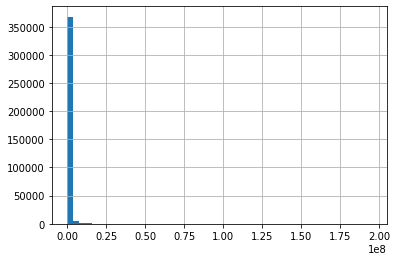

In [58]:
# Посмотрим на распределение признака
df.target.hist(bins = 50)

195000000.0 максимум
2799000.0 правый квантиль
363455


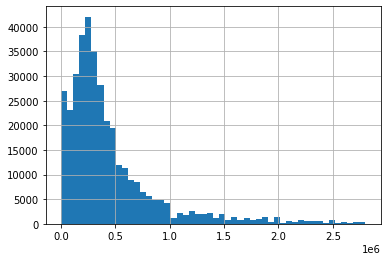

In [59]:
# Посмотрим на левую часть распределения
print(df.target.max(), 'максимум')
print(df.target.quantile(0.97),'правый квантиль')
print(df.target[df.target < 2799000.0 ].count())
df.target[df.target < 2799000.0 ].hist(bins = 50)
# Тут мы видим, что есть большое количество околонулевых значений.
# Это явно ошибки удалим их

1.0 минимум
20000.0 левый квантиль
11063


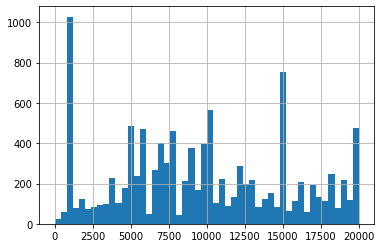

In [60]:
# Посмотрим на левую часть распределения
print(df.target.min(), 'минимум')
print(df.target.quantile(0.03),'левый квантиль')
print(df.target[df.target < 20000.0 ].count())
df.target[df.target < 20000.0 ].hist(bins = 50)
# Тут мы видим, что есть большое количество околонулевых значений.
# Это явно ошибки удалим их

In [61]:
# Удалим аномально высокие значения и маленькие
df = df.drop(df.loc[df.target > 2799000.0].index, axis = 0)
df = df.drop(df.loc[df.target < 20000.0].index, axis = 0)

In [62]:
len(df)

352445

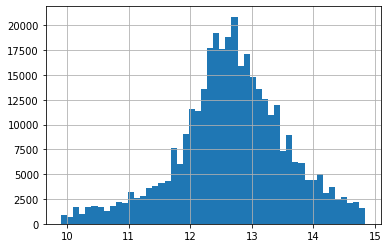

In [63]:
# Попробуем логарифмировать
np.log(df.target).hist(bins = 50)
# Распределение стало похоже на нормальное - хорошо.

## eda status

In [64]:
# Посмотрим сколько осталось домов к аренде.
df['status'][df['status'] == 'for rent']

22797     for rent
23667     for rent
180922    for rent
300847    for rent
Name: status, dtype: object

In [65]:
# Осталось только 4 обьекта их удалим. Тем более что мы хотим оценивать недвижимость к продаже а не к аренде.
df = df.loc[~df['status'].isin(['for rent'])]

## eda propertyType

In [66]:
df['status'].value_counts()

for sale    208644
active       97386
new           5969
Name: status, dtype: int64

## eda sqft

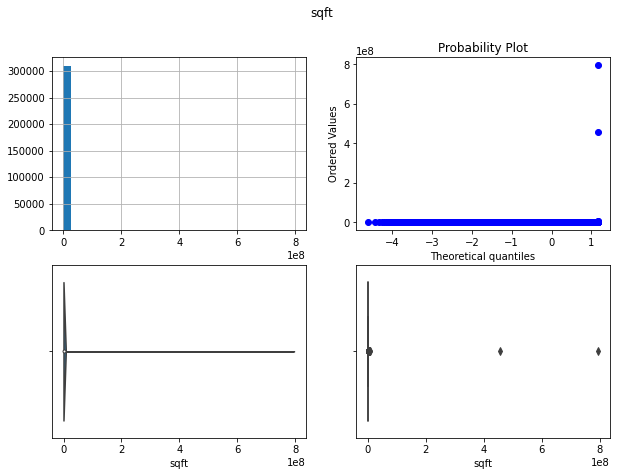

In [67]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'sqft', 'sqft')

In [68]:
# Посмотрим на границы выбросов.
# выбросов 14 тысяч это много поэтому попробуем с этим что то зделать.
get_quantile(df, 'sqft')

Верхняя граница выбросов: 4457.5 Нижняя граница выбросов: -610.5

Количество выбросов: sqft : 14021


In [69]:
# Посмотрим на значения 0.7 процента правой стороны распределения.
df.sqft.quantile(0.993)

8931.0

In [70]:
# Посмотрим на значения 0.001 процента левой стороны распределения.
df.sqft.quantile(0.001)

315.0

In [71]:
# Всего 2482 значений удалим их.
print(len(df[df.sqft > 8931]))
print(len(df[df.sqft < 150]))

2172
145


In [72]:
df = df.drop(df.loc[df.sqft > 8931].index, axis = 0)
df = df.drop(df.loc[df.sqft < 315.0].index, axis = 0)

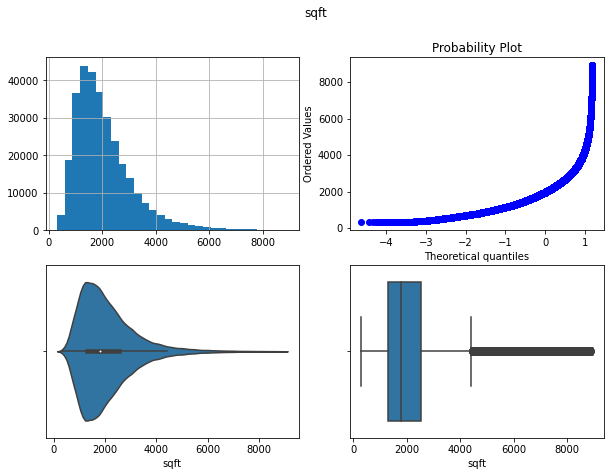

In [73]:
# График явно улучшился но есть правый хвост.
diagnostic_plots(df, 'sqft', 'sqft')

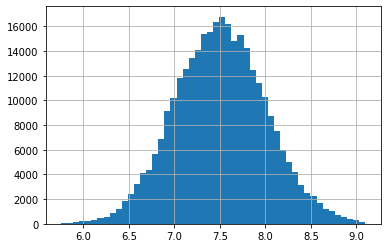

In [74]:
# Логарифмируем признак и получаем нормальное распределение - хорошо!
np.log(df.sqft).hist(bins = 50)

In [75]:
df.sqft = np.log(df.sqft)

## eda baths

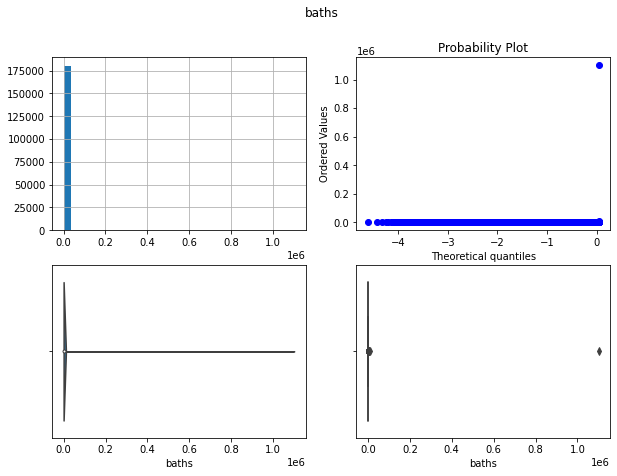

In [76]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'baths', 'baths')

In [77]:
# Посмотрим на границы выбросов.
# выбросов 13 тысяч это много поэтому попробуем с этим что то зделать.
get_quantile(df, 'baths')

Верхняя граница выбросов: 4.5 Нижняя граница выбросов: 0.5

Количество выбросов: baths : 13492


In [78]:
# Минимум максимум.
print(df.baths.max())
print(df.baths.min())

1101010.0
0.0


In [79]:
# Посмотрим на значения 0.01 процента правой стороны распределения.
df.baths.quantile(0.999)

750.0

In [80]:
# Посмотрим на значения 0.05 процента левой стороны распределения.
df.baths.quantile(0.05)

1.0

In [81]:
print(len(df[df.baths > 5]))
print(len(df[df.baths == 0]))

4639
2094


In [82]:
df.baths.median()

2.0

In [83]:
# Удалим значения больше 5
df = df.drop(df.loc[df.baths > 5].index, axis = 0)

In [84]:
df.baths = df.baths.apply(lambda x: 1 if x == 0 else x)
df.baths = df.baths.apply(lambda x: 4 if x > 5 else x)

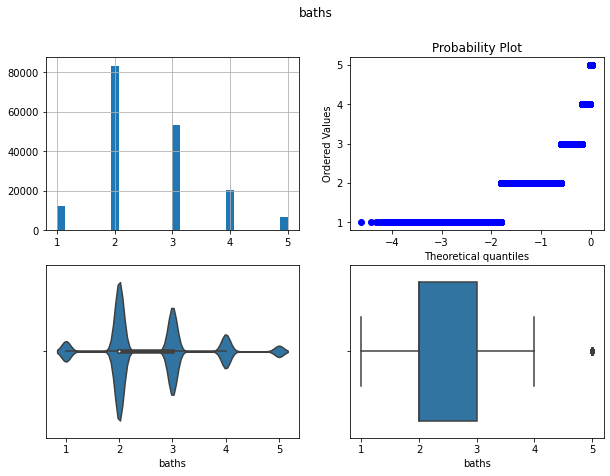

In [85]:
# График явно улучшился.
diagnostic_plots(df, 'baths', 'baths')

## beds

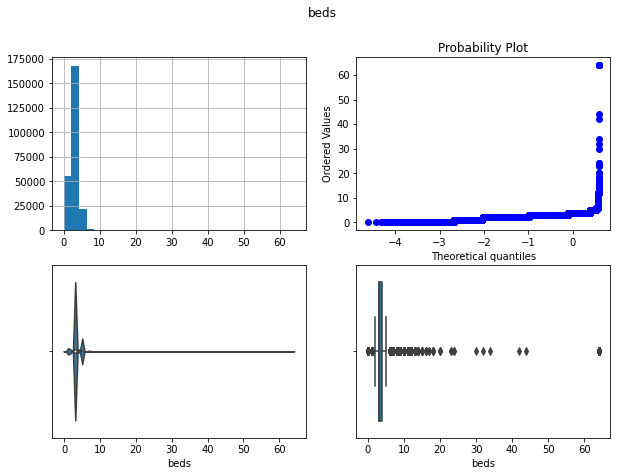

In [86]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'beds', 'beds')

In [87]:
print(df.beds.max())
print(df.beds.min())

64.0
0.0


In [88]:
print(df.beds.median())

3.0


In [89]:
print(df.beds[df.beds == 0].count())
print(df.beds[df.beds > 10].count())

1276
186


In [90]:
print(df.beds.quantile(0.999))
print(df.beds.quantile(0.001))

10.0
0.0


In [91]:
# Удалим значения больше 20
df = df.drop(df.loc[df.beds > 20].index, axis = 0)

In [92]:
# Значения которые больше 15 изменим на 4
#df.beds = df.beds.apply(lambda x: 1 if x == 0 else x)
df.beds = df.beds.apply(lambda x: 4 if x > 15 else x)

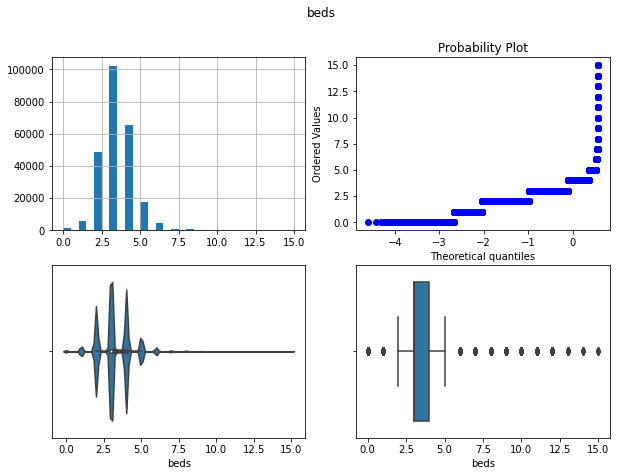

In [93]:
# График улучшился оставим так
diagnostic_plots(df, 'beds', 'beds')

## stories

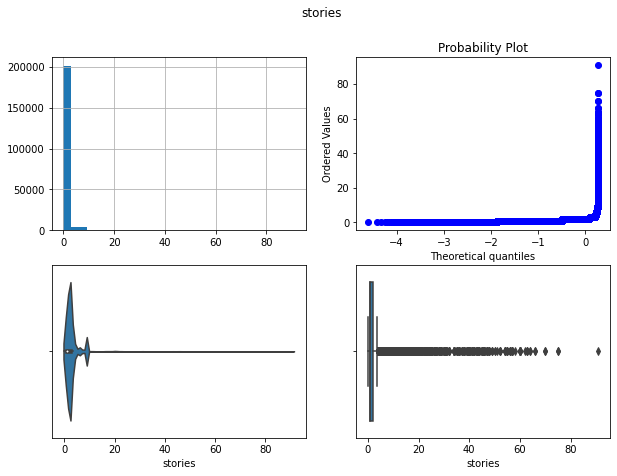

In [94]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'stories', 'stories')

In [95]:
# Крайние значения
print(df.stories.max())
print(df.stories.min())

91.0
0.0


In [96]:
print(df.stories.median())

1.0


In [97]:
print(df.stories[df.beds == 0].count())
print(df.stories[df.beds > 10].count())

695
71


In [98]:
print(df.stories.quantile(0.999))
print(df.stories.quantile(0.001))

38.0
0.0


In [99]:
# Границы выбросов
get_quantile(df, 'stories')

Верхняя граница выбросов: 3.5 Нижняя граница выбросов: -0.5

Количество выбросов: stories : 9349


In [100]:
# Значений больше 10 совсем немного удалим их
df = df.drop(df.loc[df.stories > 10].index, axis = 0)

In [101]:
# Значения 0 изменим на 1
df.stories = df.stories.apply(lambda x: 1 if x == 0 else x)
#df.stories = df.stories.apply(lambda x: 4 if x > 5 else x)

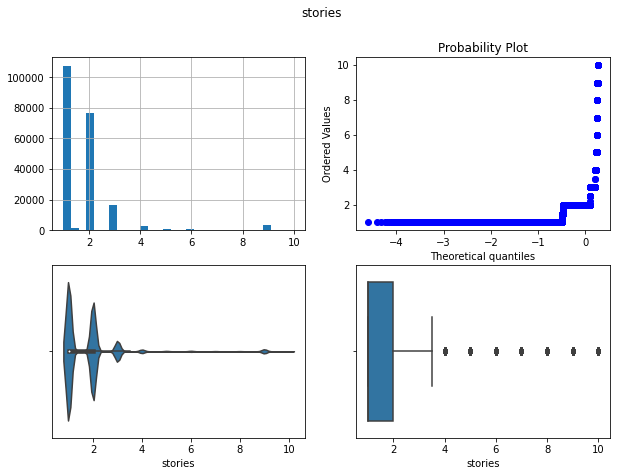

In [102]:
# График получше оставим так
diagnostic_plots(df, 'stories', 'stories')

## price_sqft

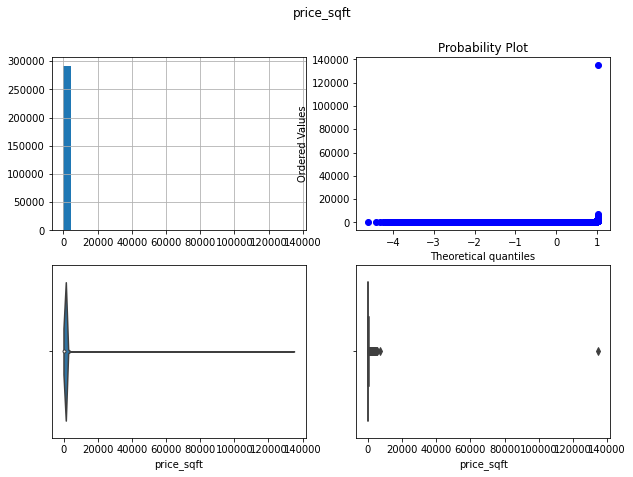

In [103]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'price_sqft', 'price_sqft')

In [104]:
# Крайние значения
print(df.price_sqft.max())
print(df.price_sqft.min())

134950.0
0.0


In [105]:
print(df.price_sqft.median())

173.0


In [106]:
print(df.price_sqft[df.price_sqft == 1].count())
print(df.price_sqft[df.price_sqft > 1500].count())

1
661


In [107]:
print(df.price_sqft.quantile(0.995))
print(df.price_sqft.quantile(0.1))

1245.0
90.0


In [108]:
# Границы выбросов
get_quantile(df, 'price_sqft')

Верхняя граница выбросов: 519.5 Нижняя граница выбросов: -116.5

Количество выбросов: price_sqft : 23751


In [109]:
#get_filling_mean(df, 'price_sqft')

In [110]:
#df = df.drop(df.loc[df.price_sqft > 2000].index, axis = 0)
#df = df.drop(df.loc[df.price_sqft == 0].index, axis = 0)

In [111]:
# Значения больше 2000 заменим на 500
# Значения 0 заменим на 1
df.price_sqft = df.price_sqft.apply(lambda x: 500 if x > 2000 else x)
df.price_sqft = df.price_sqft.apply(lambda x: 1 if x == 0 else x)

In [112]:
#df.price_sqft = np.log(df.price_sqft)

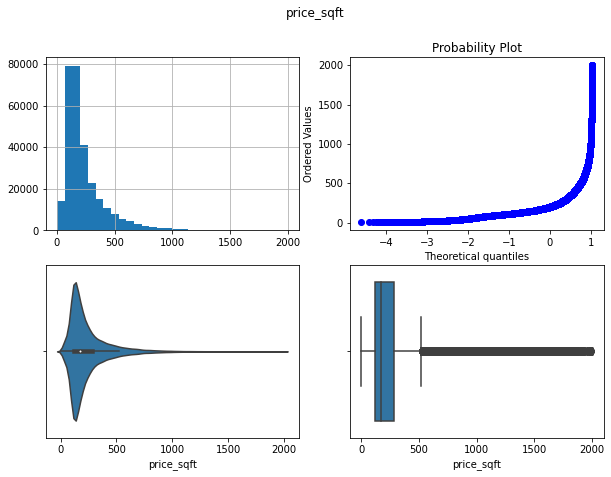

In [113]:
# График получше оставим так
diagnostic_plots(df, 'price_sqft', 'price_sqft')

## lotsize

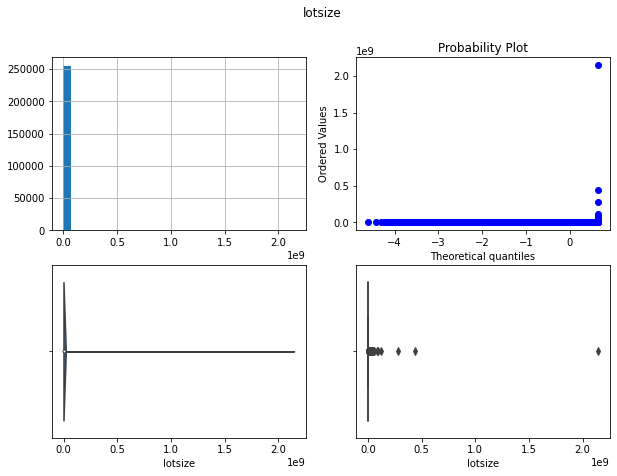

In [114]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'lotsize', 'lotsize')

In [115]:
print(df.lotsize.max())
print(df.lotsize.min())

2147483647.0
130.0


In [116]:
print(df.lotsize.median())

7843.0


In [117]:
print(df.lotsize[df.lotsize == 0].count())
print(df.lotsize[df.lotsize < 1761119].count())

0
254203


In [118]:
print(df.lotsize.quantile(0.99))
print(df.lotsize.quantile(0.01))

794307.8879999666
696.4200000000001


In [119]:
get_quantile(df, 'lotsize')

Верхняя граница выбросов: 27648.0 Нижняя граница выбросов: -8908.800000000001

Количество выбросов: lotsize : 35432


In [120]:
len(df.loc[df.lotsize > 200000])

8939

In [121]:
df = df.drop(df.loc[df.lotsize > 820909].index, axis = 0)
#df = df.drop(df.loc[df.price_sqft == 0].index, axis = 0)

In [122]:
#df.lotsize = np.log(df.lotsize)

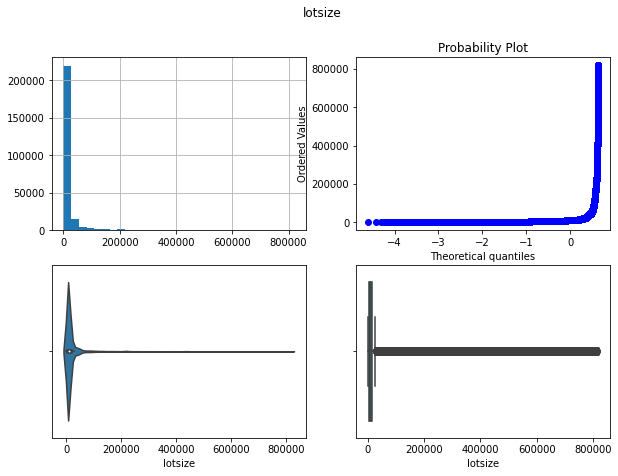

In [123]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'lotsize', 'lotsize')

## Heatmap


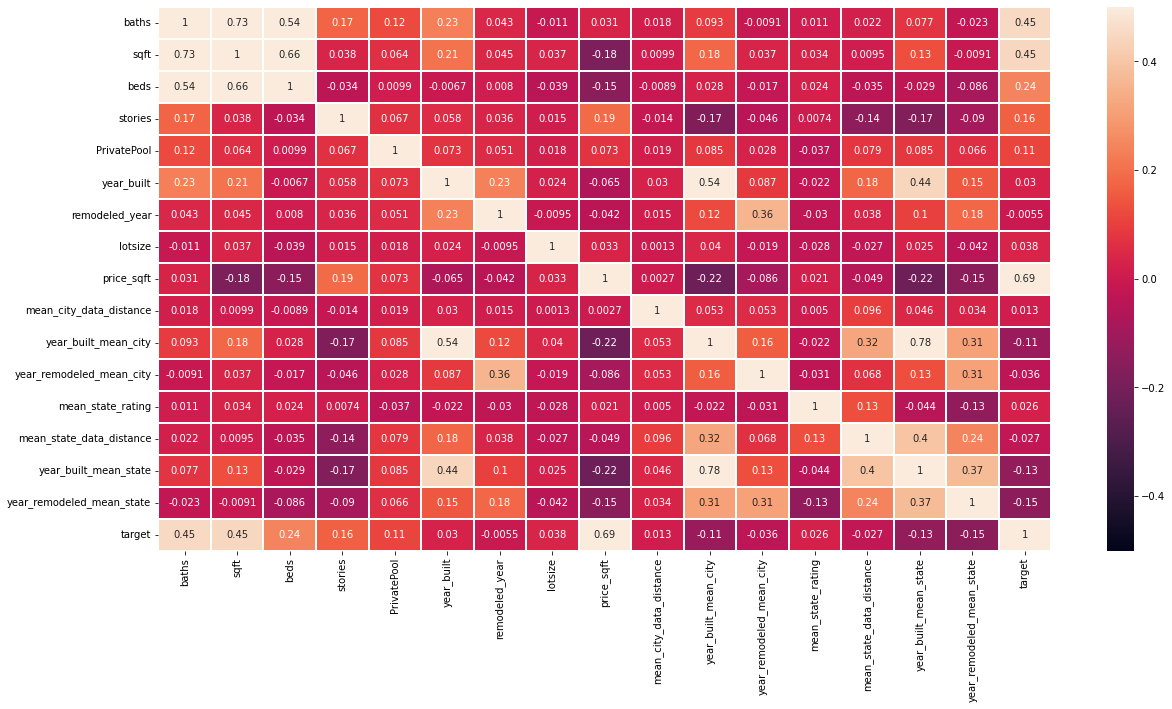

In [124]:
# Построим таблицу кореляций 

num_col = ['baths','sqft','beds','stories','PrivatePool','year_built','remodeled_year','lotsize','price_sqft','mean_city_data_distance','year_built_mean_city',
           'year_remodeled_mean_city','mean_state_rating','mean_state_data_distance','year_built_mean_state','year_remodeled_mean_state','target']


plt.rcParams['figure.figsize'] = (20,10)
sns.heatmap(df[num_col].corr(),linecolor = "white", annot = True,linewidths = 1,vmax = 0.5, vmin = -0.5)

# Сохранение датасета после FE и EDA

In [126]:
df.to_csv('/content/gdrive/MyDrive/Diplom_project/df_func_after_FE_EDA_map.csv')

# Наивная модель

In [62]:
data = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/df_func_map.csv').drop(['Unnamed: 0',"'one houses'","'unknown'","'manufactured - '","'two houses'",], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [64]:
# При загрузке датасета проявляються столбцы с одинаковыми названиями применим функцию которая это исправит.

def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

data = df_column_uniquify(data)

In [65]:
# Разделим признаки на числовые и категориальные
num_col = ['baths','sqft','beds','stories','PrivatePool','year_built',
           'remodeled_year','lotsize','price_sqft','mean_city_data_distance','year_built_mean_city',
           'year_remodeled_mean_city','mean_state_rating','mean_state_data_distance',
           'year_built_mean_state','year_remodeled_mean_state']


cat = ['status', 'propertyType', 'street',
       'city', 'sqft', 'zipcode','state', 'heating',
       'parking',
       'propertyType_1','parking_','fireplace','cooling','name',	'data_distance',	'data_grades','rating','rating_sum',	'rating_mean',	'rating_median','data_distance_sum','data_distance_mean','data_distance_median']



In [66]:
y = data.target
data.drop(['target'], inplace = True,axis = 1)

In [67]:
# Закодируем категориальные признаки.
for colum in cat:
  data[colum] = data[colum].astype('category').cat.codes

In [68]:
# split данных
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)

In [69]:
model_cat = CatBoostRegressor(iterations = 5000,
                          learning_rate = 0.01,
                          l2_leaf_reg=2,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',

                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         #plot=True
         )

0:	learn: 1.4651907	test: 1.4782435	best: 1.4782435 (0)	total: 175ms	remaining: 14m 35s
1000:	learn: 0.2842970	test: 0.2903811	best: 0.2903811 (1000)	total: 1m 48s	remaining: 7m 14s
2000:	learn: 0.2473301	test: 0.2557928	best: 0.2557928 (2000)	total: 3m 30s	remaining: 5m 15s
3000:	learn: 0.2341589	test: 0.2440671	best: 0.2440620 (2998)	total: 5m 12s	remaining: 3m 27s
4000:	learn: 0.2249477	test: 0.2361502	best: 0.2361498 (3999)	total: 6m 55s	remaining: 1m 43s
4999:	learn: 0.2188080	test: 0.2313764	best: 0.2313764 (4999)	total: 8m 34s	remaining: 0us

bestTest = 0.231376363
bestIteration = 4999



In [70]:
# Не очень хороший результат.
test_predict_catboost = model_cat.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST mae: {(mae(y_test, test_predict_catboost)):0.2f}$")

TEST mape: 23.14%
TEST mae: 40476.19$


In [ ]:
# Итоговый датасет.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341561 entries, 0 to 341560
Columns: 449 entries, status to mean_city_PrivatePool
dtypes: float64(316), int64(117), object(16)
memory usage: 1.1+ GB
